In [1]:
import belief
import tasks
import various_methods

import numpy as np
from matplotlib import pyplot as plt

In [2]:
skill_required_work = {
    0: [50, 50, 1], #identify_fm
    1: [50, 50, 1], #identify_buzzer
    2: [50, 50, 1], #identify_touch_plate
    3: [50, 50, 1], #identify_reed_switch
    4: [50, 50, 1], #identify_button_switch
    5: [50, 50, 1], #identify_normal_switch
    6: [50, 50, 1], #identify_cds
    7: [50, 50, 1], #identify_led
    8: [50, 50, 1], #identify_lamp
    9: [50, 50, 1], #identify_battery
    10: [50, 50, 1], #identify_speaker
    11: [50, 50, 1], #identify_mc
    12: [50, 50, 1], #identify_motor
    13: [20, 40, 0], #connect_pieces
    14: [100, 150, 0], #close_circuit
    15: [100, 150, 0], #series_circuit
    16: [150, 150, 0], #parallel_circuit
    17: [100, 150, 0], #led_pos_stud
    18: [100, 150, 0], #led_neg_stud
    19: [100, 150, 0], #fm_in_stud
    20: [100, 150, 0], #fm_out_stud
    21: [150, 200, 0], #fm_signal_stud
    22: [100, 150, 0], #mc_in_stud
    23: [100, 150, 0], #mc_out_stud
    24: [150, 200, 0], #mc_trigger_stud
    25: [150, 200, 0], #mc_repeat_stud
    26: [150, 200, 0], #mc_restart_stud
}

In [3]:
def create_collabTDBKTs(sids, uids, masteries, discussion_time, solve_time):
    beliefs = {}
    
    for sid in sids:
        p_L_0s = {}
        for uid in uids:
            p_L_0s[uid] = masteries[uid][sid]

        skill = tasks.sid_skill_map[sid]
        skill_probs = skill.skill_probs

        skill_belief = belief.GroupSkillBelief(sname=skill.skill_name,
                                        sid=sid, 
                                        uids=uids, 
                                        p_L_0s=p_L_0s, 
                                        p_S=skill_probs.prob_slipping, 
                                        p_G=skill_probs.prob_guessing, 
                                        p_T=skill_probs.prob_learning,
                                        n=10, 
                                        discussion_time=discussion_time,
                                        solve_time=solve_time)
        beliefs[sid] = skill_belief
    return beliefs

def create_TDBKTs(sids, uids, masteries, discussion_time, solve_time):
    beliefs = {}
    
    for sid in sids:
        p_L_0s = {}
        for uid in uids:
            p_L_0s[uid] = masteries[uid][sid]

        skill = tasks.sid_skill_map[sid]
        skill_probs = skill.skill_probs

        skill_belief = various_methods.GenericGroupSkillBelief(sname=skill.skill_name,
                                        sid=sid, 
                                        uids=uids, 
                                        p_L_0s=p_L_0s, 
                                        p_S=skill_probs.prob_slipping, 
                                        p_G=skill_probs.prob_guessing, 
                                        p_T=skill_probs.prob_learning,
                                        n=10, 
                                        discussion_time=discussion_time,
                                        solve_time=solve_time,
                                        usb=various_methods.TDBKT)
        beliefs[sid] = skill_belief
    return beliefs

In [4]:
def pick_skills(skill_pick_prob):
    sids = []
    for sid in tasks.sid_skill_map:
        
        if sid == 9:
            sids.append(sid)
            continue
        elif sid == 13:
            sids.append(sid)
            continue
        elif sid == 14:
            sids.append(sid)
            continue
        elif sids == 15:
            series_or_parallel = np.random.choice([15, 16])
            sids.append(series_or_parallel)
            break
        else:
            picked = np.random.choice([0, 1], p=[1 - skill_pick_prob, skill_pick_prob])
            if picked:
                sids.append(sid)
                if sid == 7:
                    sids.append(17)
                    sids.append(18)
                elif sid == 0:
                    sids.append(19)
                    sids.append(20)
                    sids.append(21)
                elif sid == 11:
                    sids.append(22)
                    sids.append(23)
                    picked_stud = np.random.choice([23, 24, 25])
                    sids.append(picked_stud)

    return sids


In [5]:
def simulate_task(uids, current_real_masteries, collab_believed_masteries, solo_believed_masteries, discussion_time, solve_time):
    real_masteries = {}
    for uid in uids:
        real_masteries[uid] = {}
        for sid in tasks.sid_skill_map:
            real_masteries[uid][sid] = [current_real_masteries[uid][sid]]

    total_time = discussion_time + solve_time

    skill_pick_prob = np.random.uniform(0, 1, 1)[0]
    sids = pick_skills(skill_pick_prob)
    print(sids)

    collab_tdbkts = create_collabTDBKTs(sids, uids, collab_believed_masteries, discussion_time, solve_time)
    tdbkts = create_TDBKTs(sids, uids, solo_believed_masteries, discussion_time, solve_time)

    time = 0

    working_towards = {}
    working_against = {}
    observations = {}
    actions = {}
    for sid in sids:
        observations[sid] = 0
        working_towards[sid] = {}
        working_against[sid] = {}
        actions[sid] = {}
        for uid in uids:
            working_towards[sid][uid] = 0
            working_against[sid][uid] = 0
            actions[sid][uid] = 0

    

    while True:

        for sid in sids:
            
            skill_probs = tasks.sid_skill_map[sid].skill_probs
            unique = skill_required_work[sid][2]

            for uid in uids:
                works_on_prob = current_real_masteries[uid][sid] * (1 - skill_probs.prob_slipping) + (1 - current_real_masteries[uid][sid]) * skill_probs.prob_guessing
                if unique:
                    if observations[sid] == 0:
                        working_towards[sid][uid] += np.random.choice([0, 1], p=[1 - works_on_prob, works_on_prob])
                    else:
                        working_against[sid][uid] += np.random.choice([0, 1], p=[works_on_prob, 1 - works_on_prob])
                else:
                    working_towards[sid][uid] += np.random.choice([0, 1], p=[1 - works_on_prob, works_on_prob])
                    working_against[sid][uid] += np.random.choice([0, 1], p=[works_on_prob, 1 - works_on_prob])

            skill_done = 0
            skill_undone = 0
            for uid in uids:
                skill_done += working_towards[sid][uid]
                skill_undone += working_against[sid][uid]

            do_required = np.random.uniform(skill_required_work[sid][0] - 10, skill_required_work[sid][0] + 10, 1)[0]
            undo_required = np.random.uniform(skill_required_work[sid][1] - 10, skill_required_work[sid][1] + 10, 1)[0]
            

            if skill_done > do_required and (not unique or not observations[sid]):
                observations[sid] = 1
                for uid in uids:
                    old_contr = actions[sid][uid]
                    new_contr = working_towards[sid][uid] / skill_done
                    if new_contr > old_contr:
                        actions[sid][uid] = new_contr
                    working_towards[sid][uid] = 0
                    working_against[sid][uid] = 0
                    probs_learn = skill_probs.prob_learning
                    learns = np.random.choice([0, 1], p=[1 - probs_learn, probs_learn])
                    if current_real_masteries[uid][sid] == 0 and learns == 1:
                        current_real_masteries[uid][sid] = 1
            elif skill_undone > undo_required and (not unique or observations[sid]):
                observations[sid] = 0
                for uid in uids:
                    working_towards[sid][uid] = 0
                    working_against[sid][uid] = 0

        for sid in collab_tdbkts:
            c_ts = {}
            for uid in uids:
                if observations[sid] == 1:
                    c_ts[uid] = actions[sid][uid]
                else:
                    c_ts[uid] = 0
            collab_tdbkts[sid].step(observations[sid], c_ts)
            tdbkts[sid].step(observations[sid], c_ts)
        
        for uid in uids:
            for sid in tasks.sid_skill_map:
                if sid in collab_tdbkts:
                    real_masteries[uid][sid].append(current_real_masteries[uid][sid])
                else:
                    real_masteries[uid][sid].append(real_masteries[uid][sid][-1])

        if time > total_time:
            break
        time += 1

    for sid in collab_tdbkts:
        collab_belief = collab_tdbkts[sid]
        solo_belief = tdbkts[sid]
        for uid in collab_belief.users:
            collab_believed_masteries[uid][sid] = collab_belief.users[uid].H[-1]
            solo_believed_masteries[uid][sid] = solo_belief.users[uid].H[-1]

    return collab_tdbkts, tdbkts, real_masteries, collab_believed_masteries, solo_believed_masteries


In [6]:
def plot_masteries(real_masteries):
    for uid in real_masteries:
        for sid in real_masteries[uid]:
            mastery = real_masteries[uid][sid]
        
            plt.figure(figsize=(10, 2))
            plt.plot(np.arange(len(mastery)), np.array(mastery), linestyle='-')

            plt.xlabel('Time Step')
            plt.ylabel('Real Mastery')
            plt.title('Real Mastery SID: ' + str(sid) + ' ' + tasks.sid_skill_map[sid].skill_name+ ' UID: ' + str(uid))

            plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.show()

In [7]:
def find_correctness(beliefs, real_masteries):
    total_dist = 0
    num_dist = 0

    for sid in beliefs:
        skill_belief = beliefs[sid]
        for uid in skill_belief.users:
            current_mastery = real_masteries[uid][sid]
            current_belief = skill_belief.users[uid].H
            true_values = np.array(current_mastery)
            dist = np.linalg.norm(current_belief-true_values)
            total_dist += dist
            num_dist += 1
            

    avg_dist = total_dist / num_dist
    return avg_dist

In [8]:
uids = [0, 1]

current_real_masteries = {}
collab_believed_masteries = {}
solo_believed_masteries = {}

for uid in uids:
    current_real_masteries[uid] = {}
    collab_believed_masteries[uid] = {}
    solo_believed_masteries[uid] = {}
    for sid in tasks.sid_skill_map:
        collab_believed_masteries[uid][sid] = 0.5
        solo_believed_masteries[uid][sid] = 0.5
        current_real_masteries[uid][sid] = np.random.randint(2)

[0, 19, 20, 21, 1, 2, 3, 4, 5, 6, 7, 17, 18, 8, 9, 10, 11, 22, 23, 24, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26]
6.242815224004033
6.3058434705306805


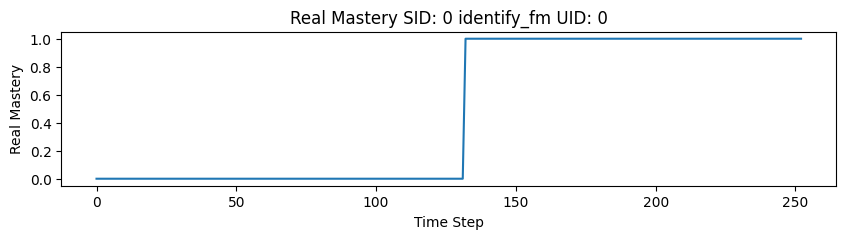

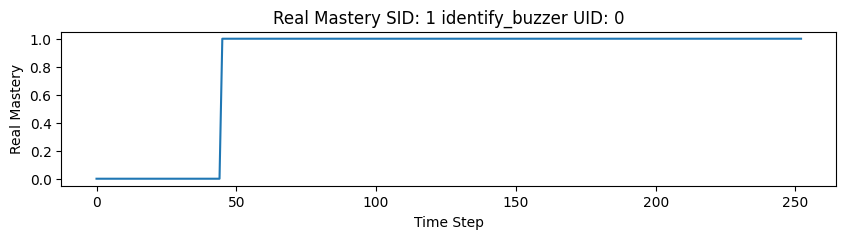

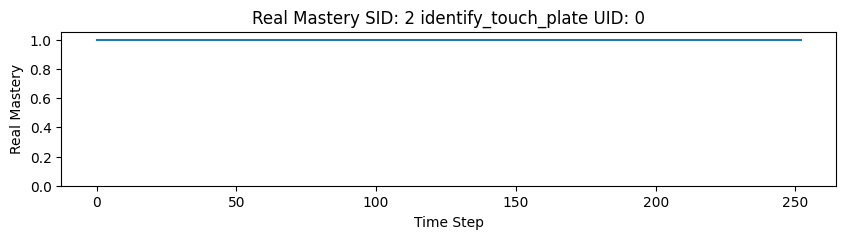

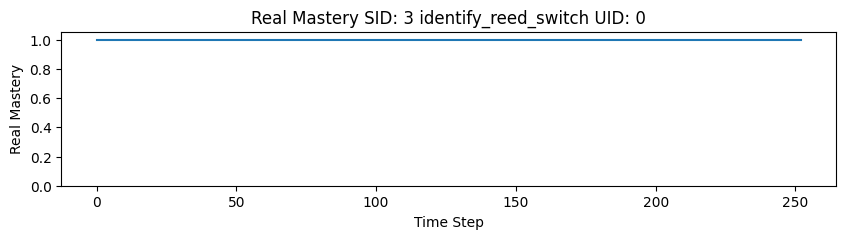

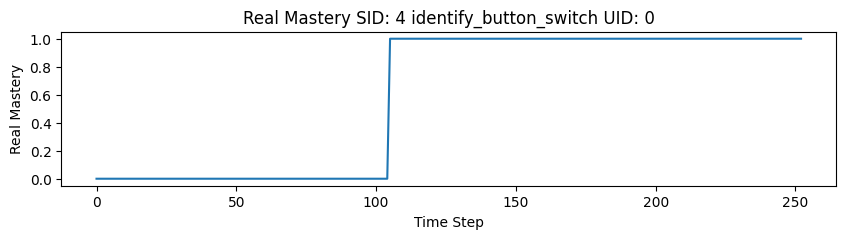

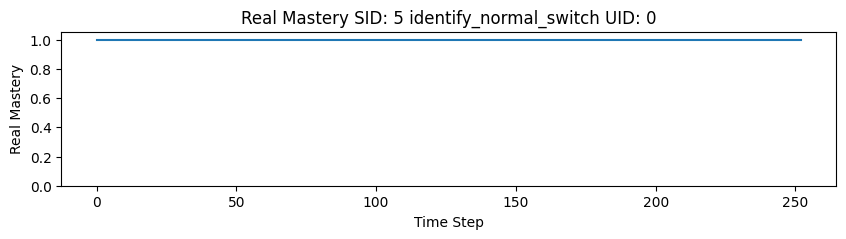

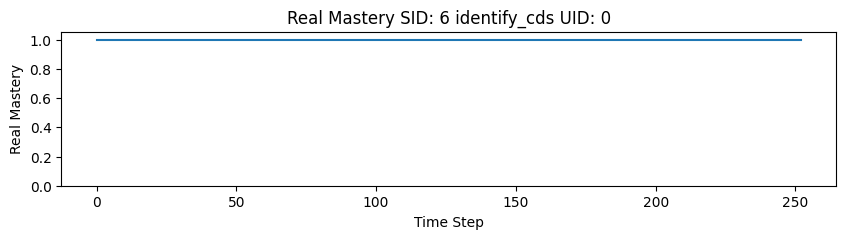

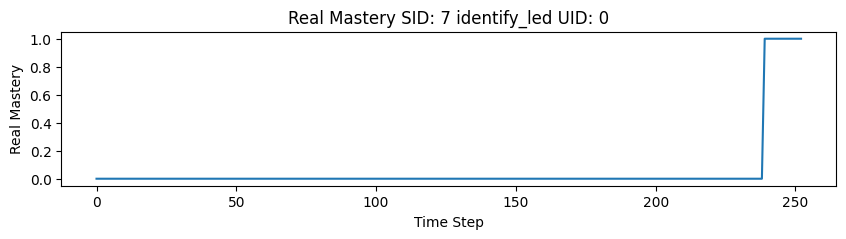

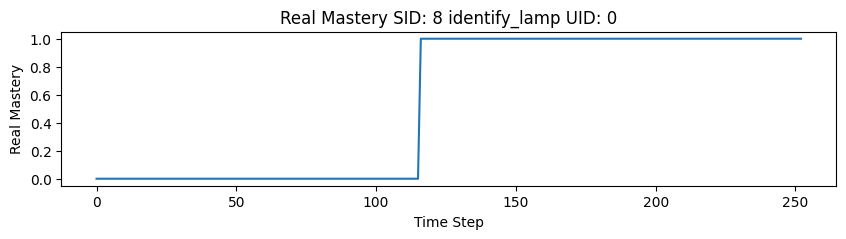

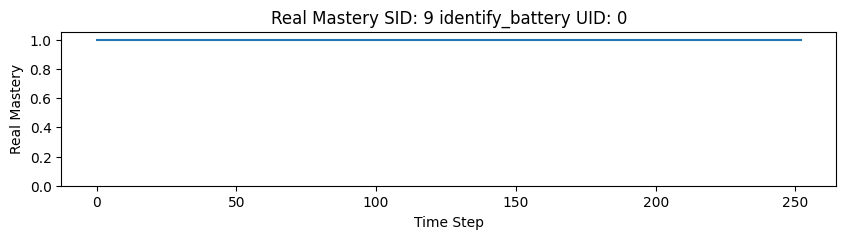

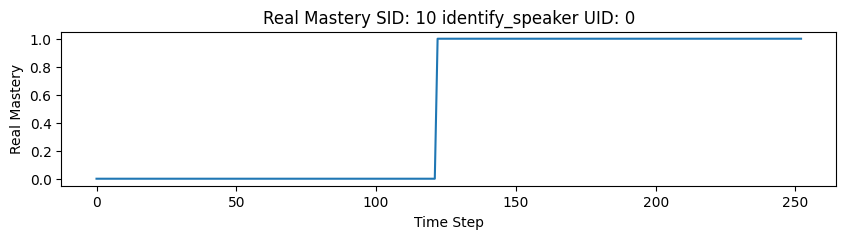

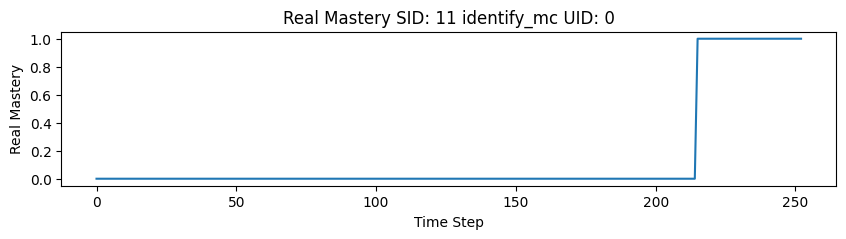

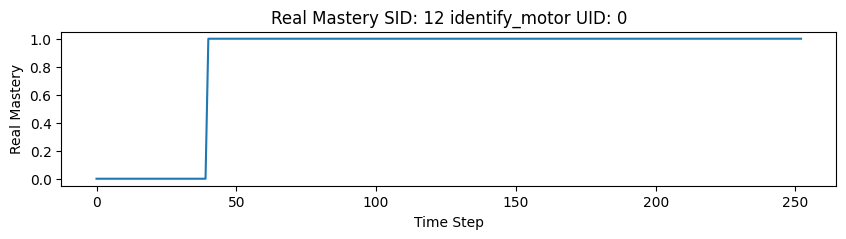

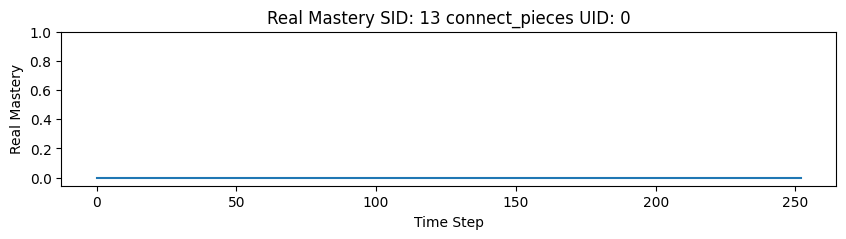

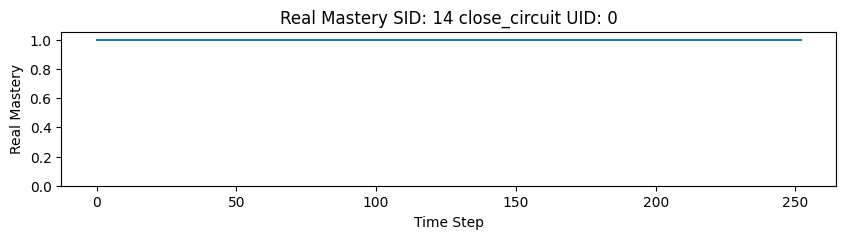

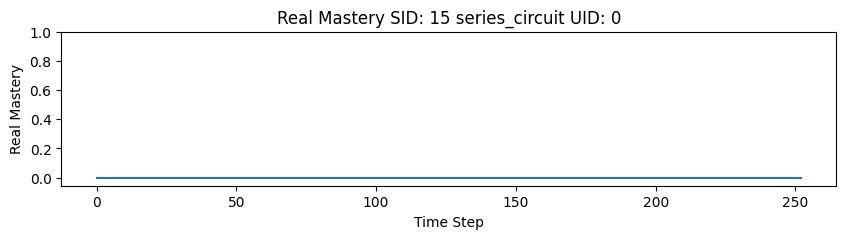

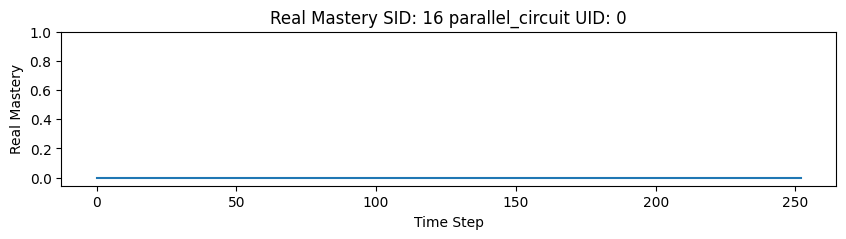

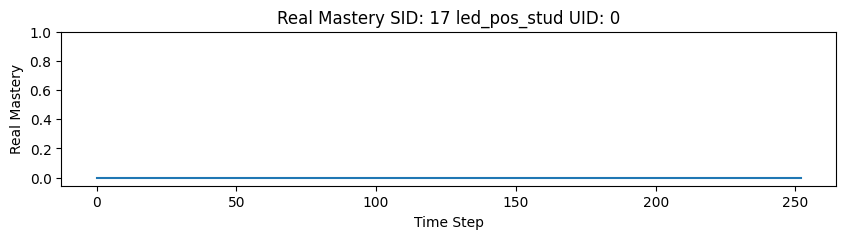

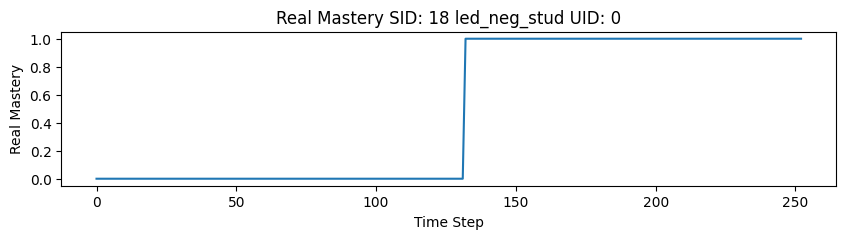

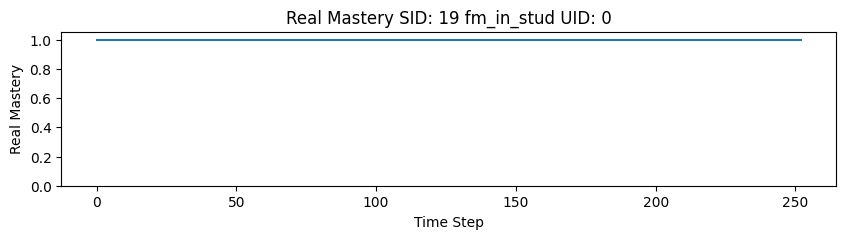

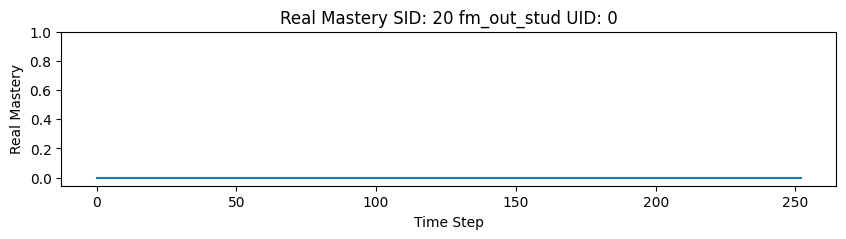

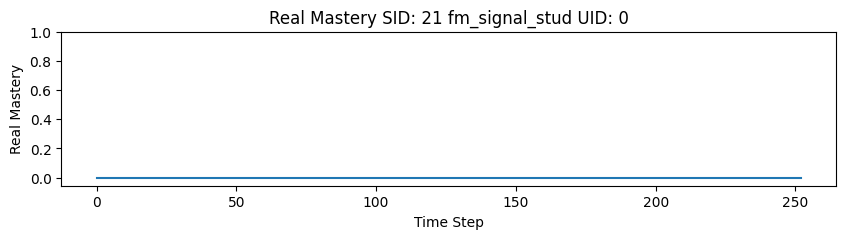

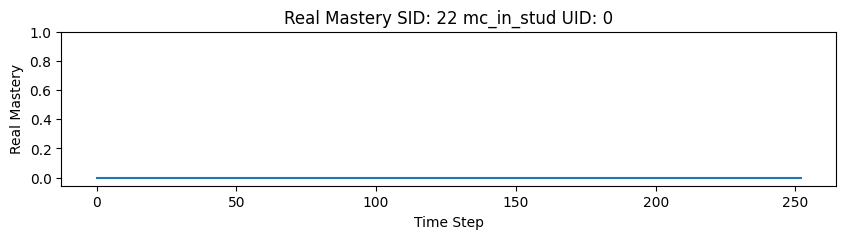

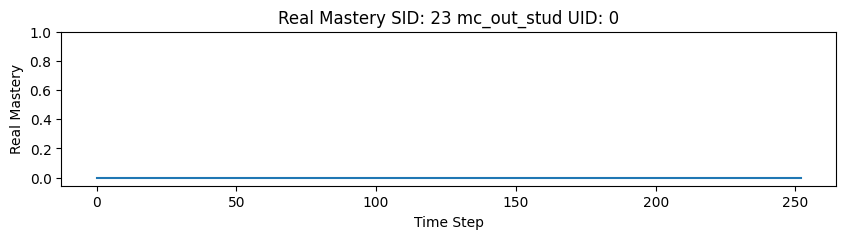

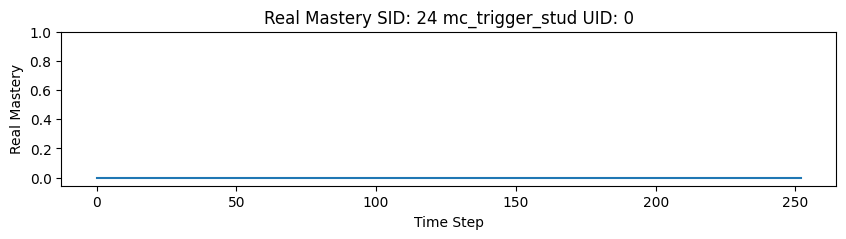

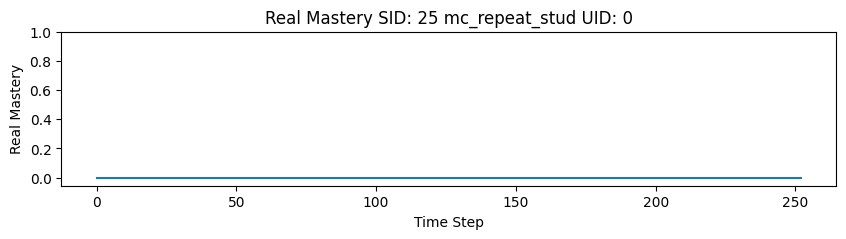

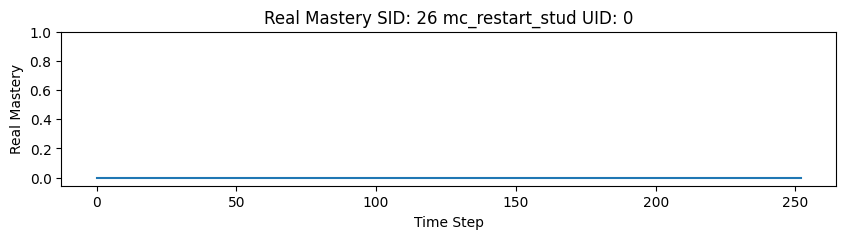

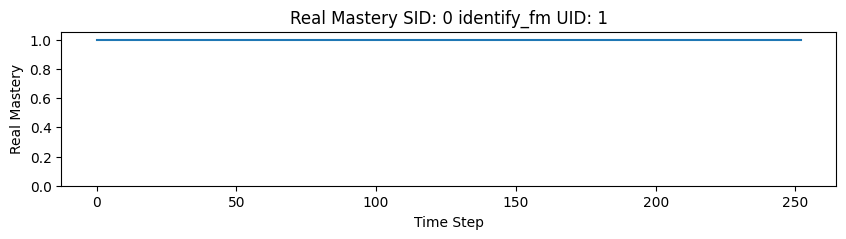

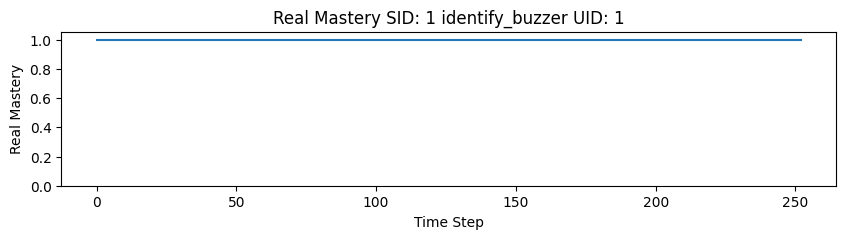

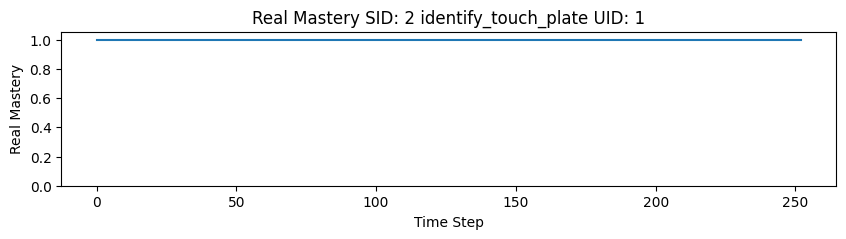

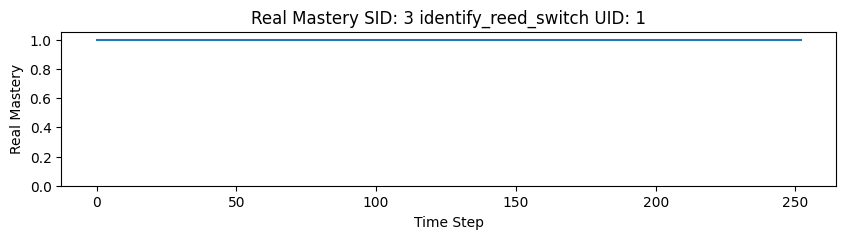

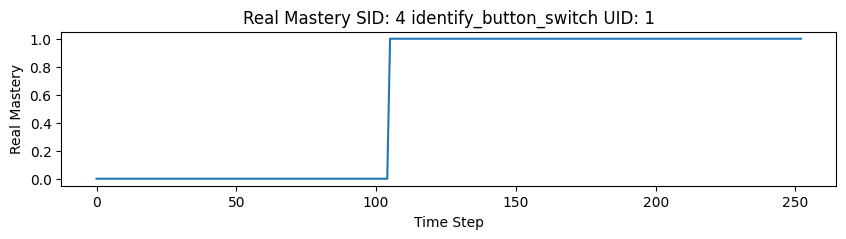

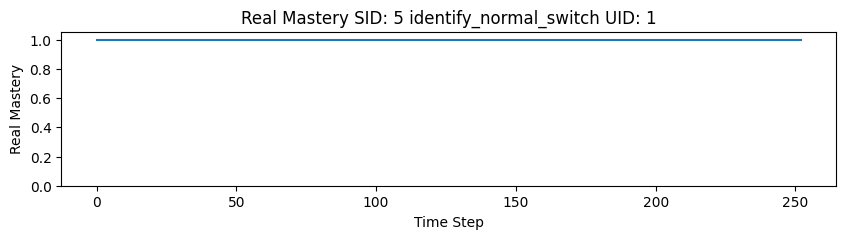

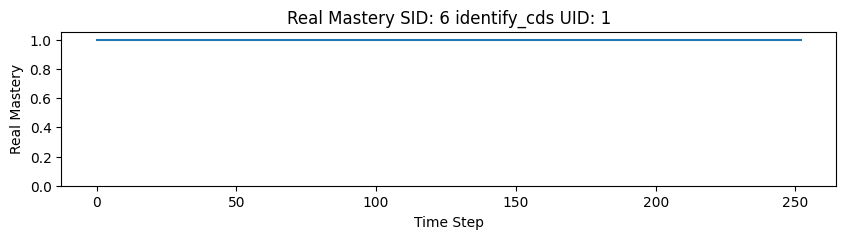

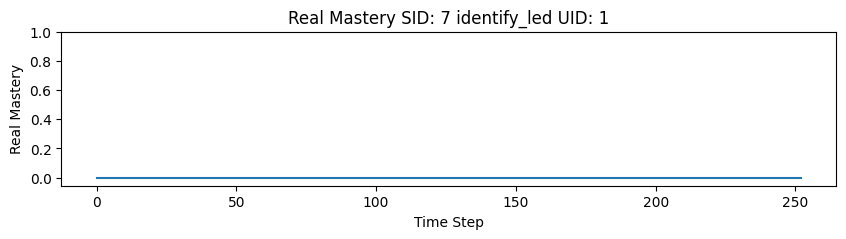

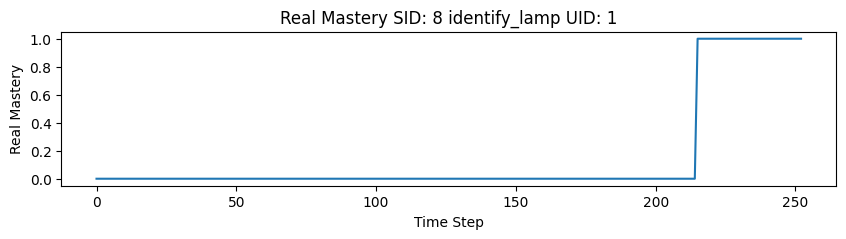

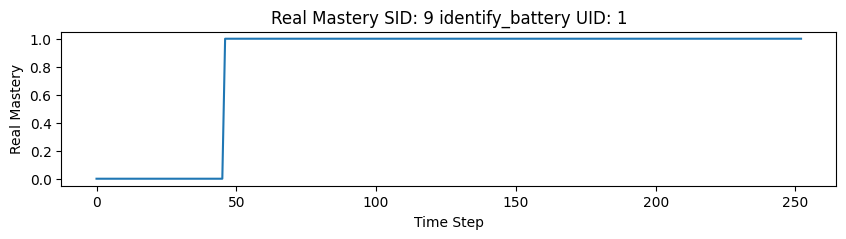

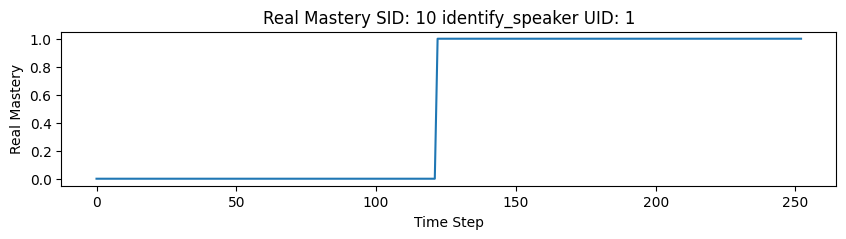

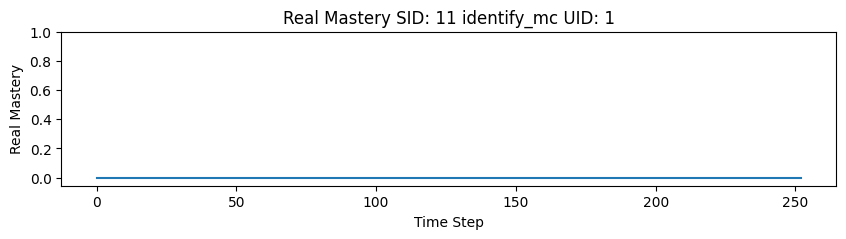

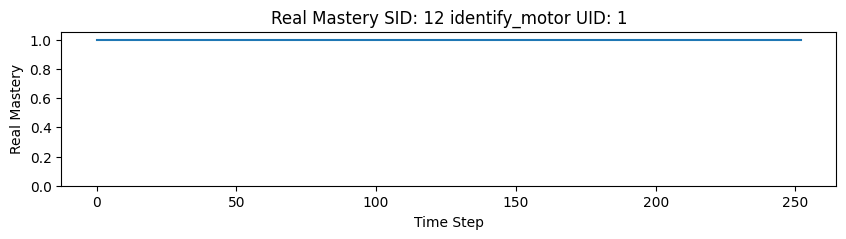

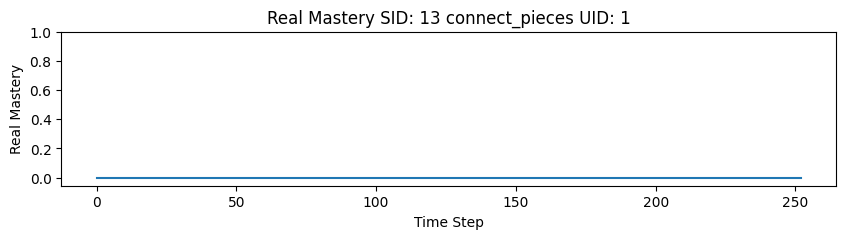

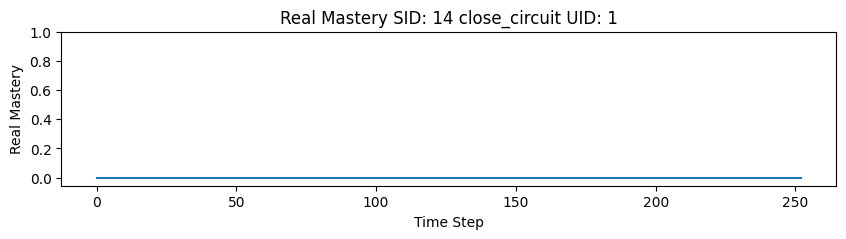

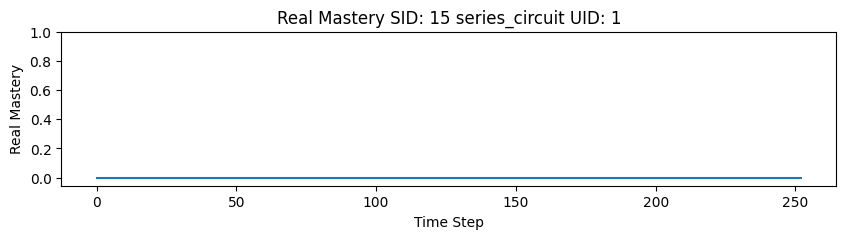

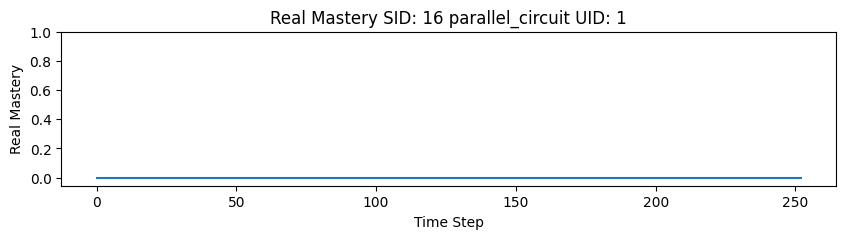

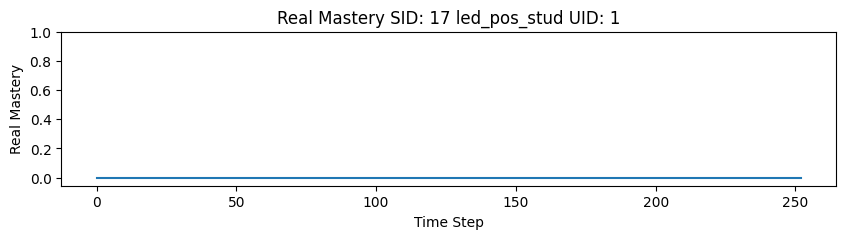

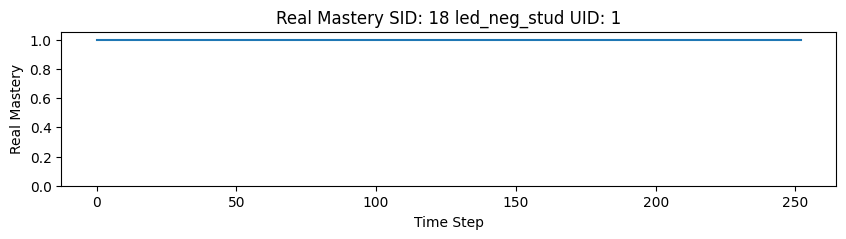

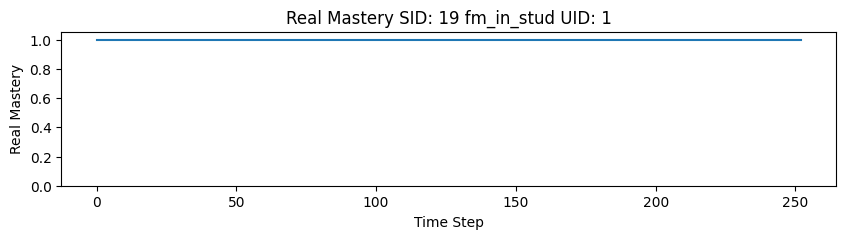

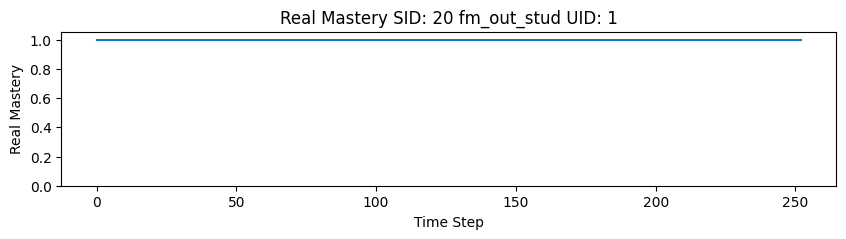

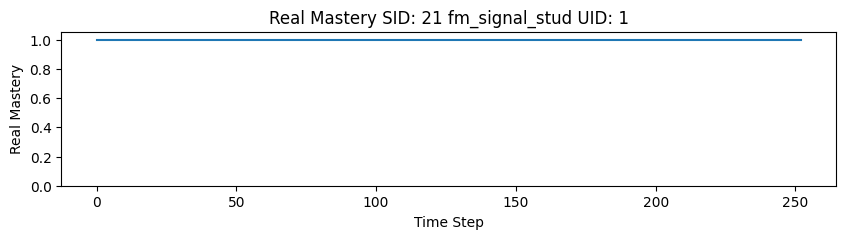

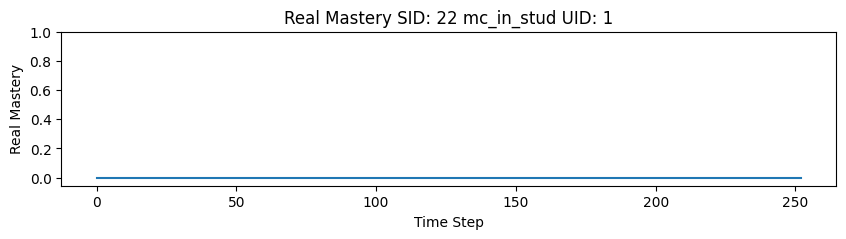

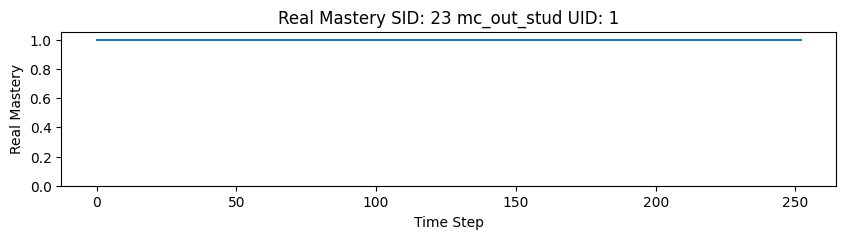

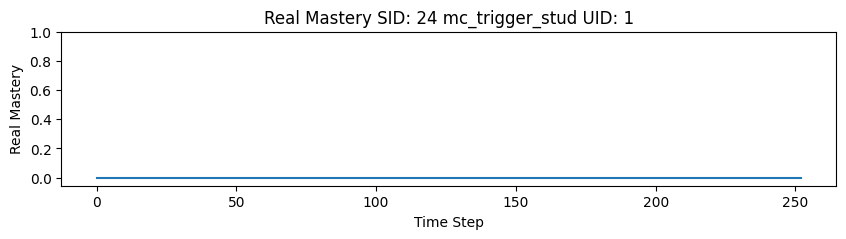

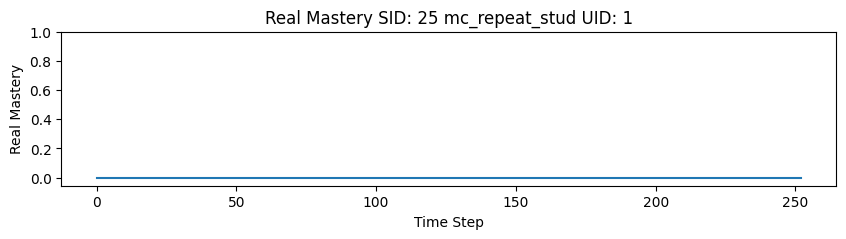

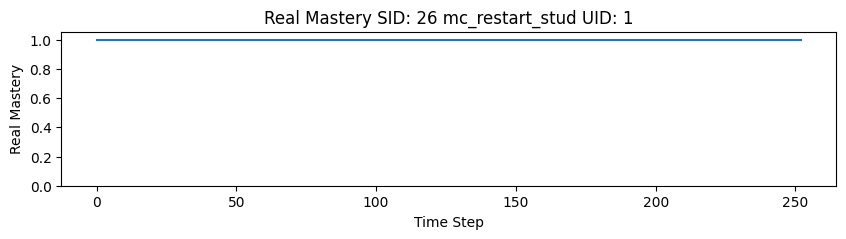

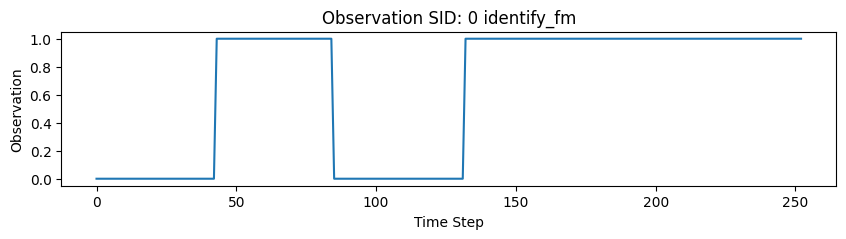

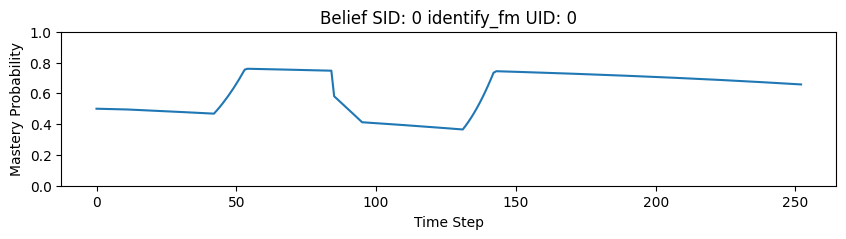

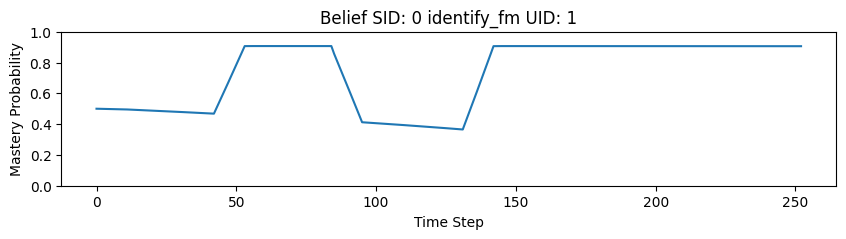

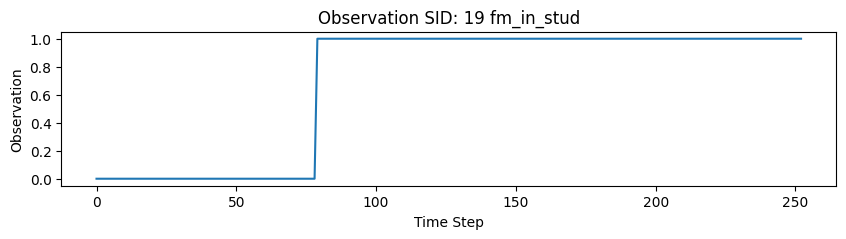

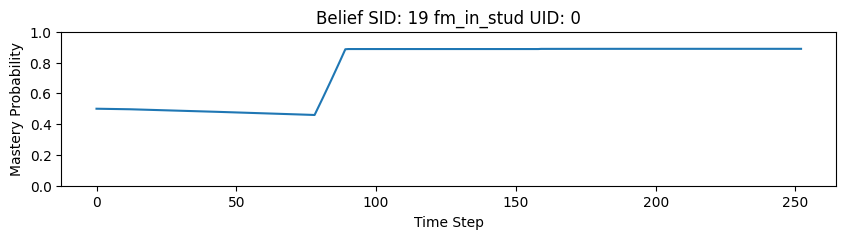

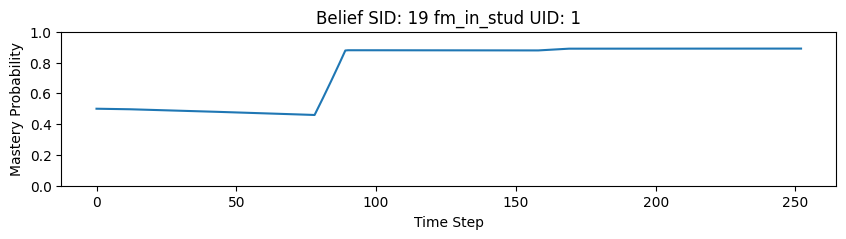

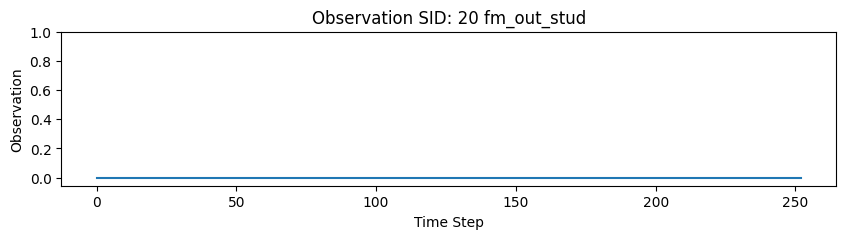

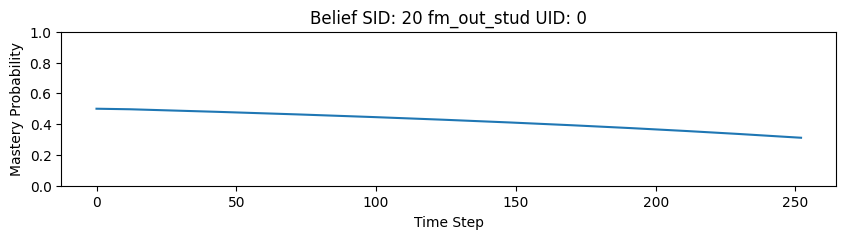

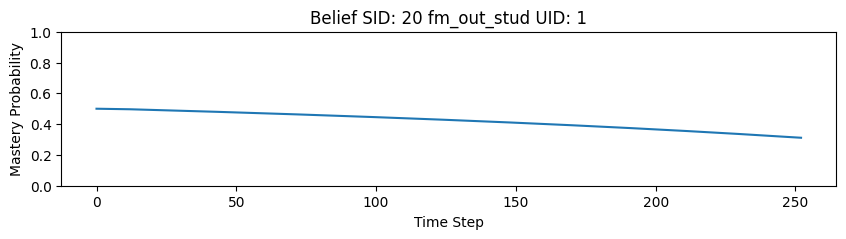

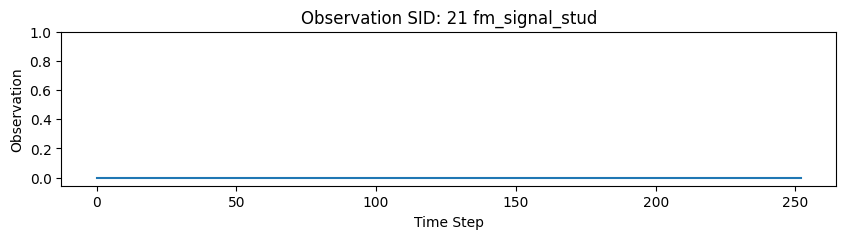

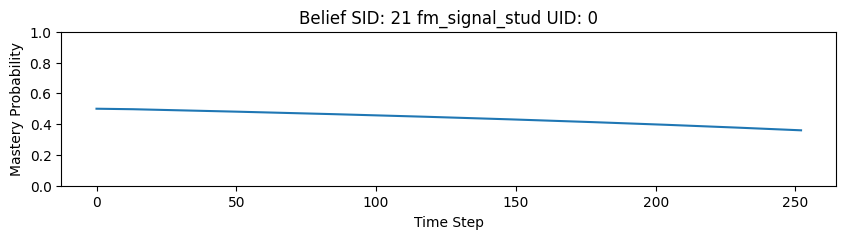

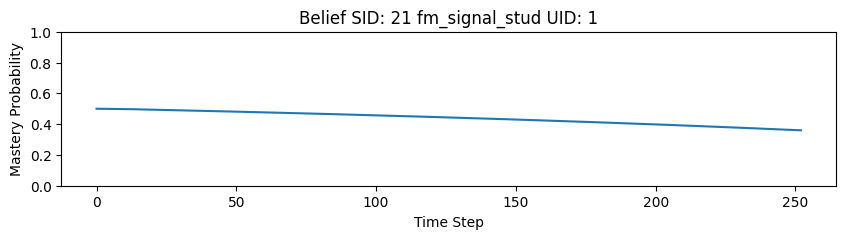

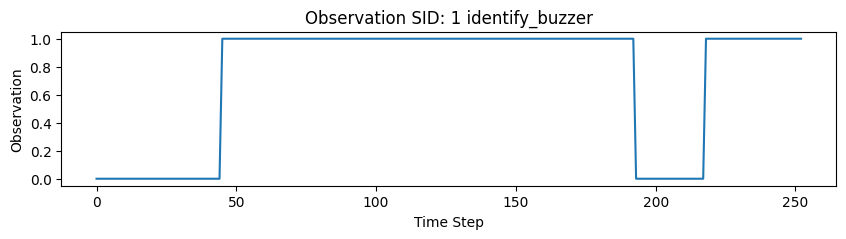

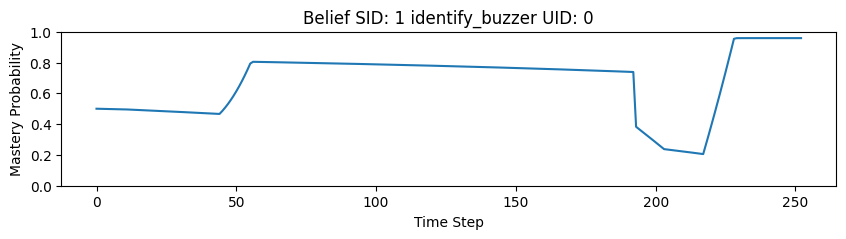

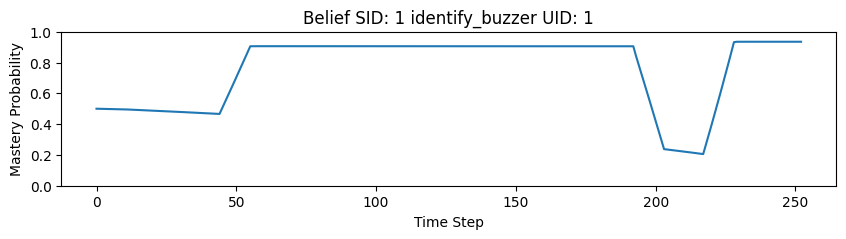

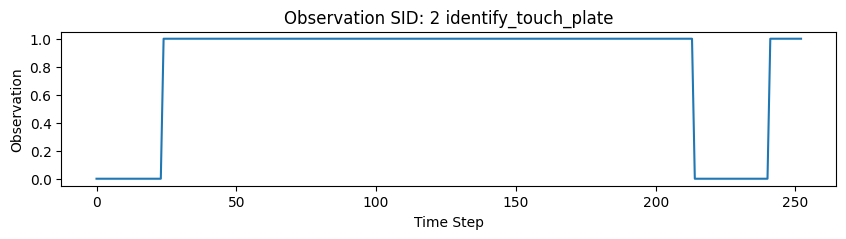

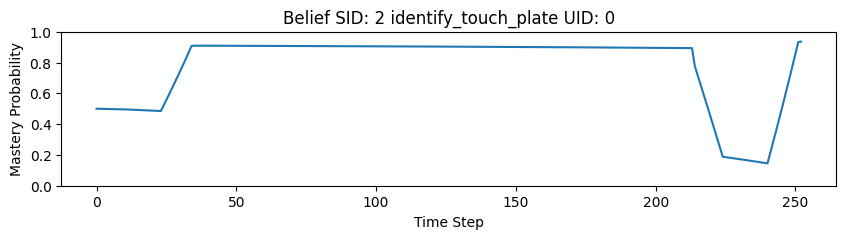

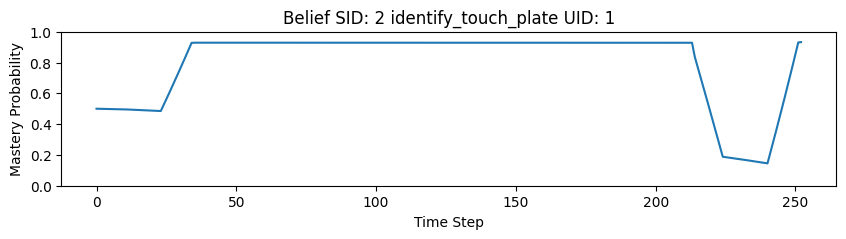

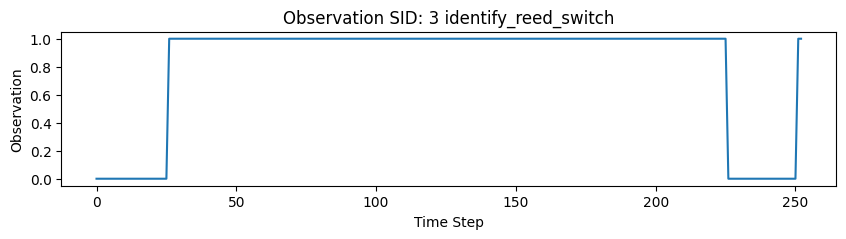

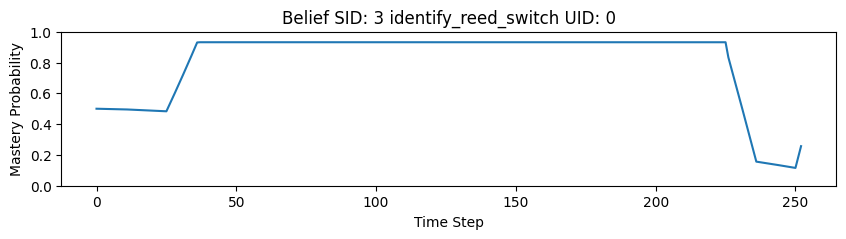

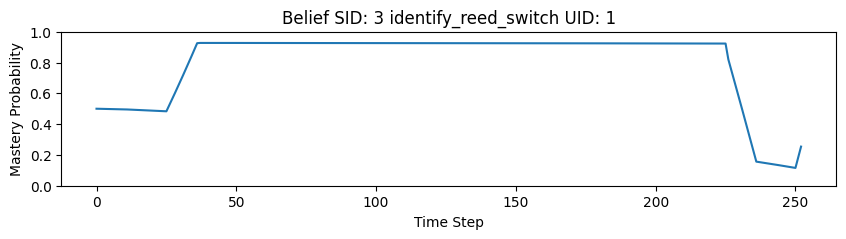

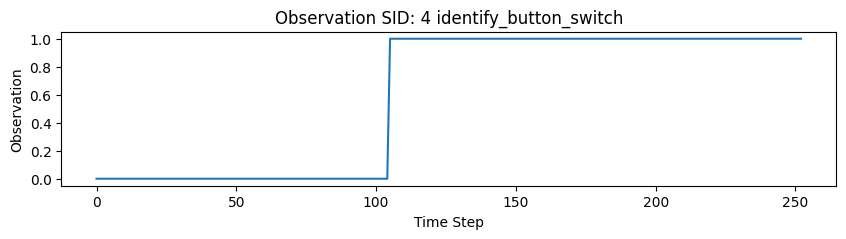

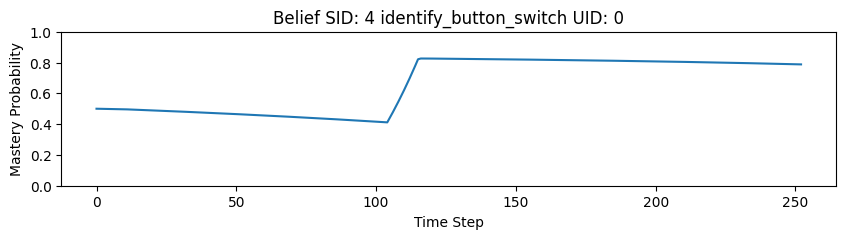

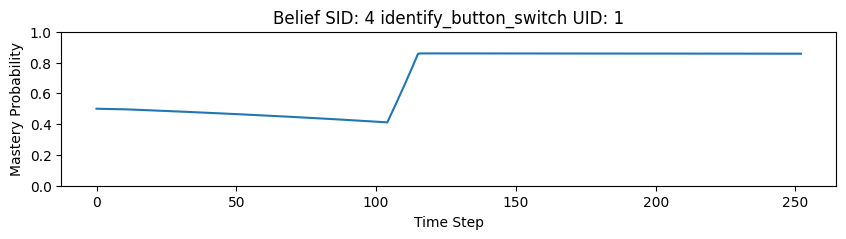

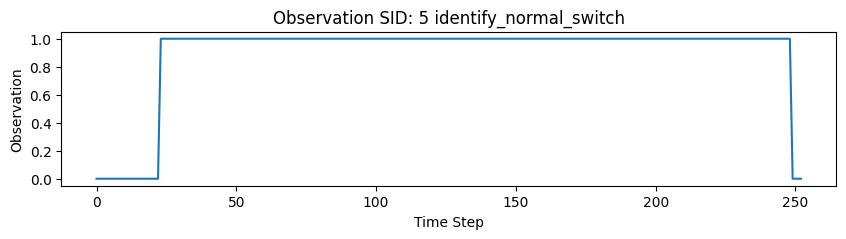

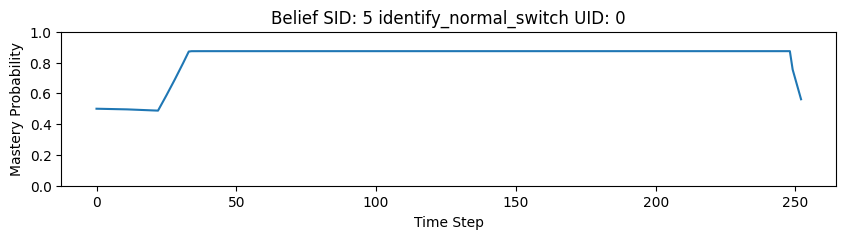

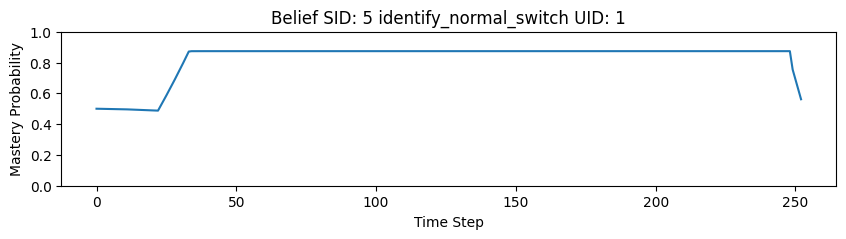

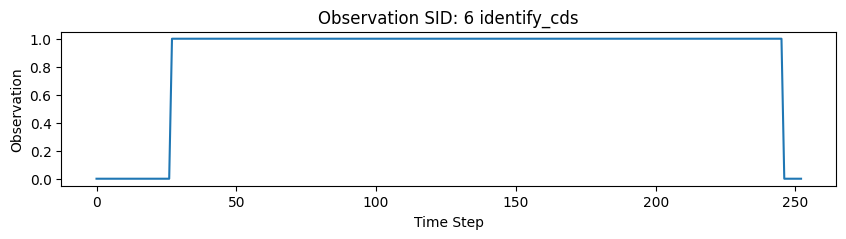

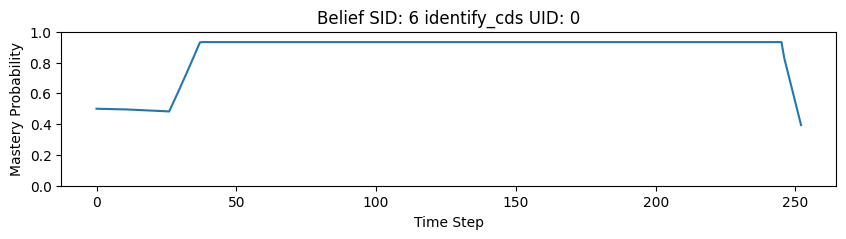

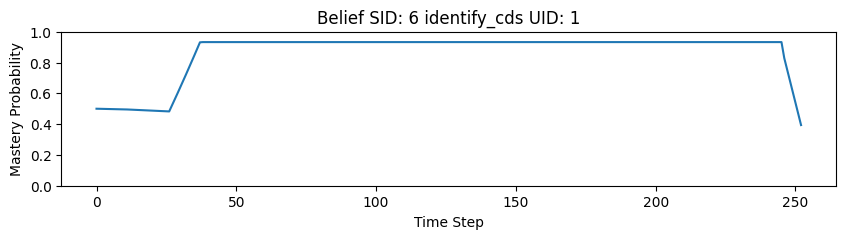

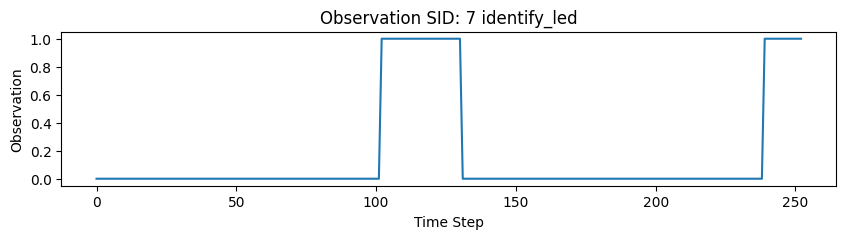

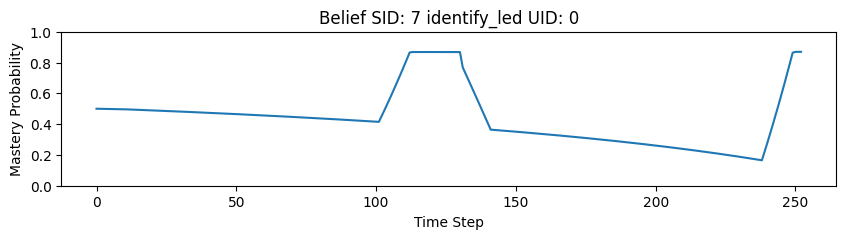

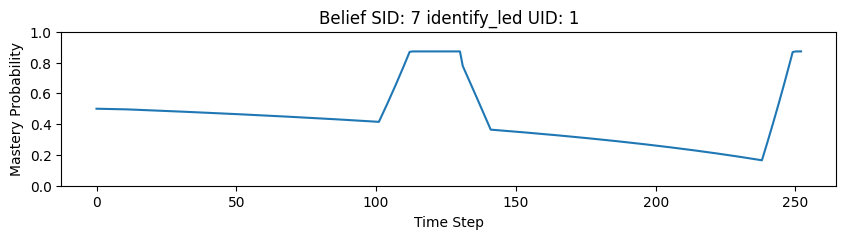

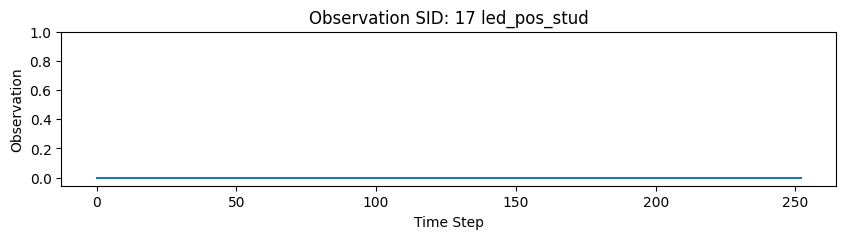

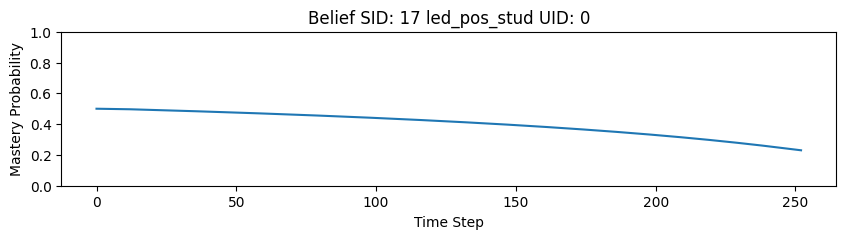

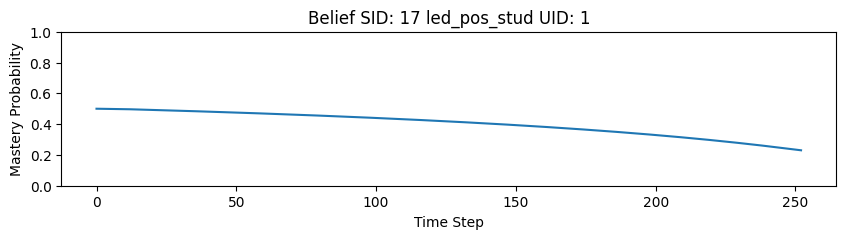

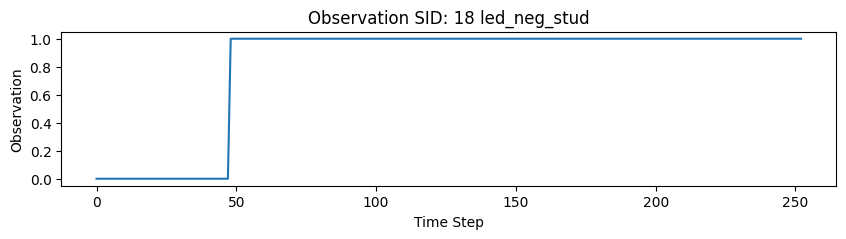

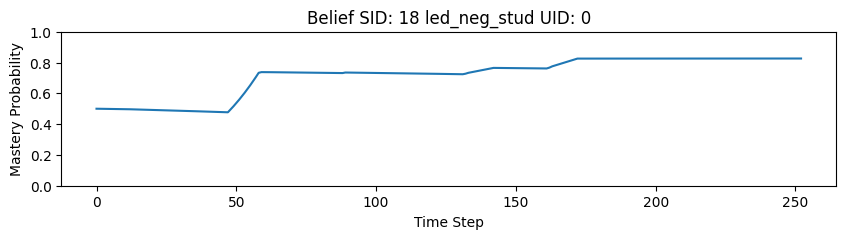

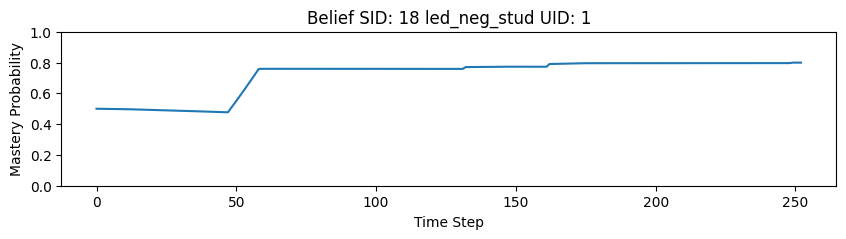

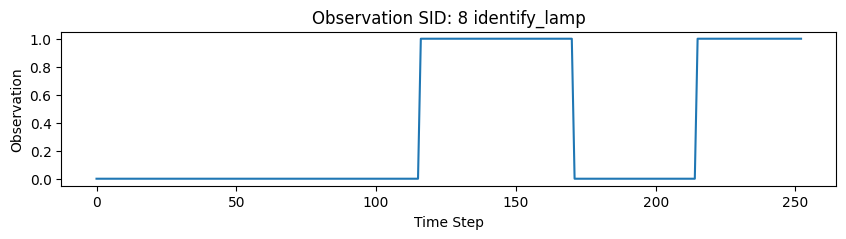

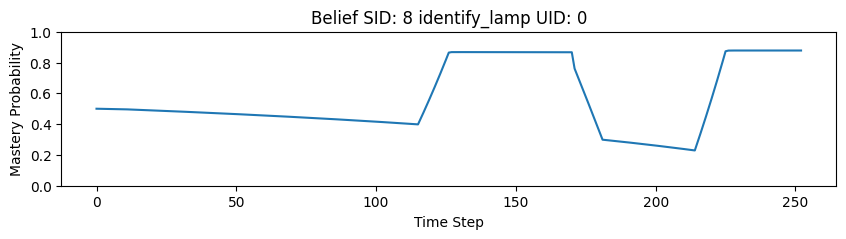

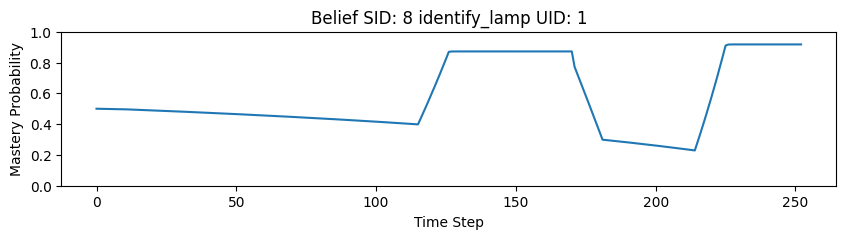

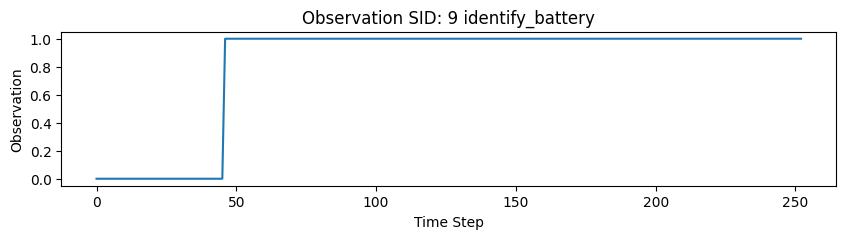

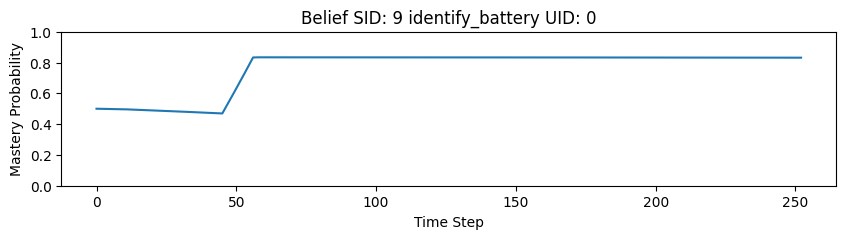

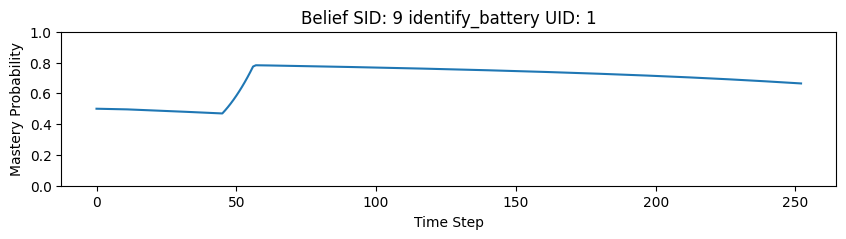

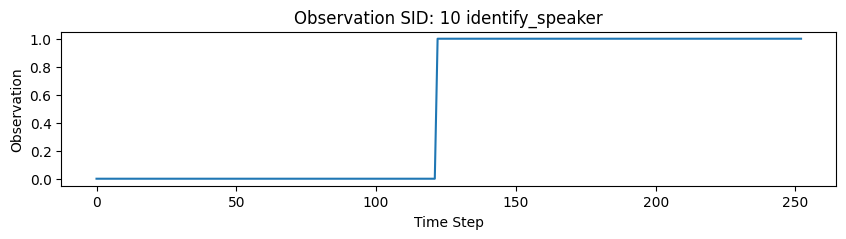

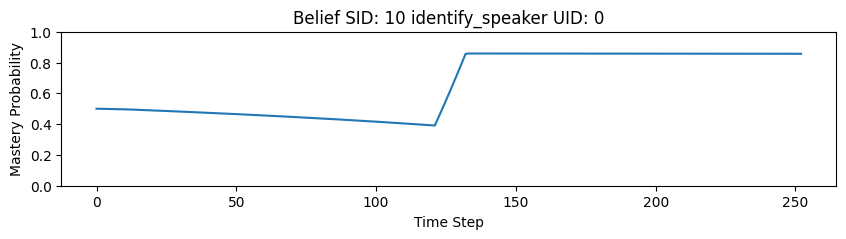

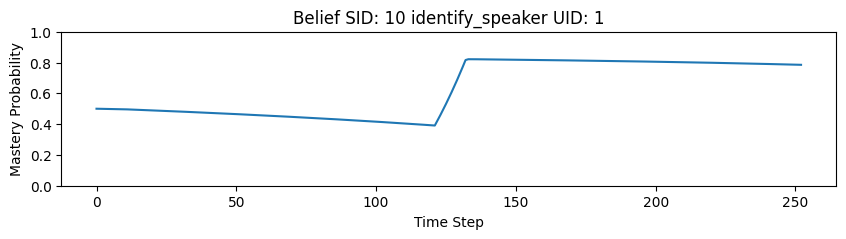

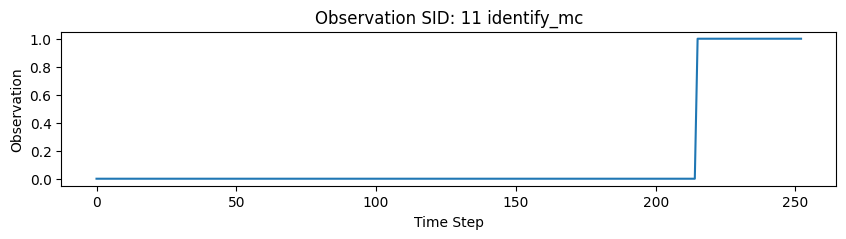

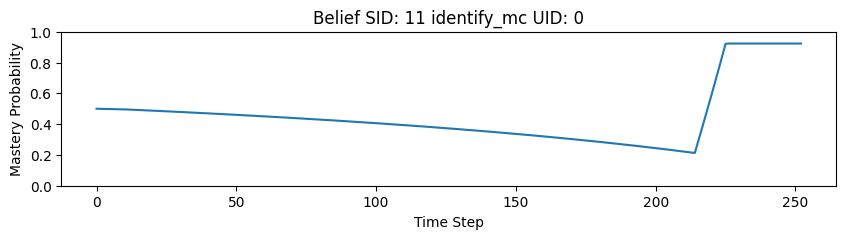

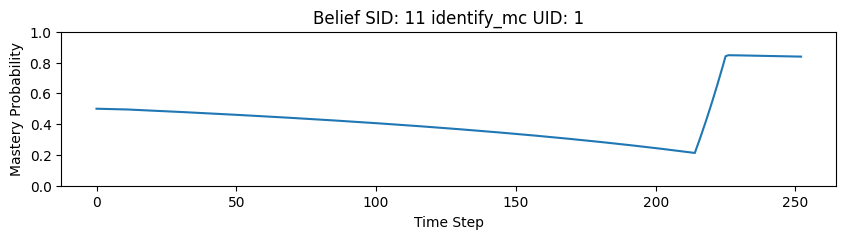

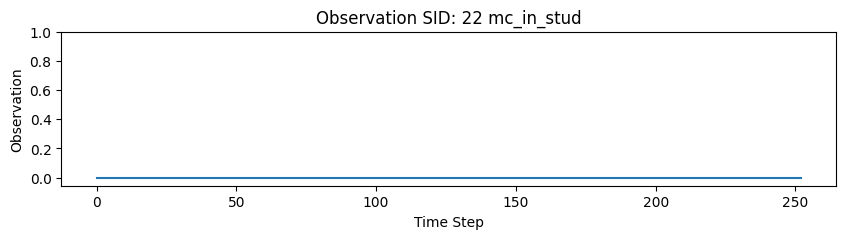

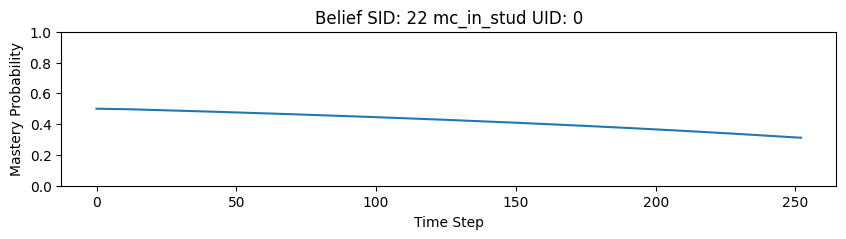

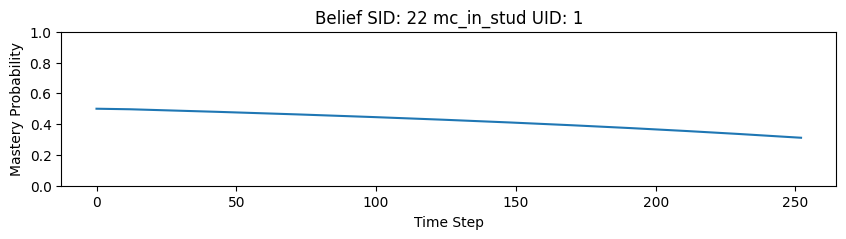

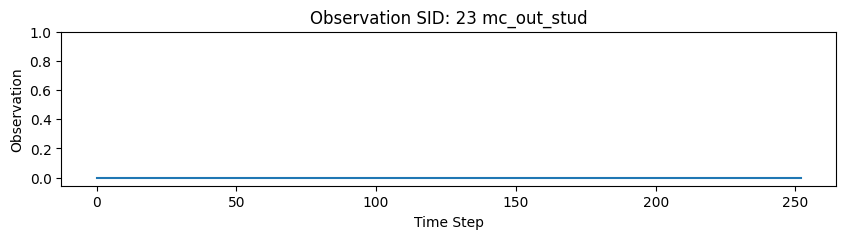

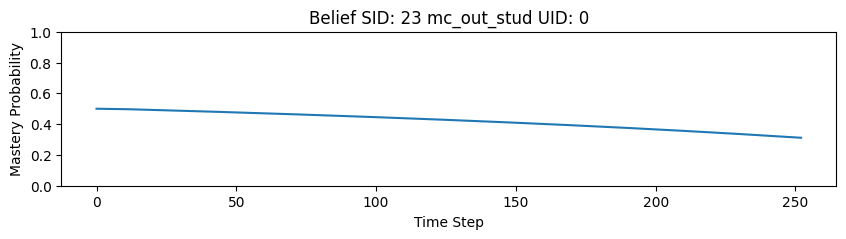

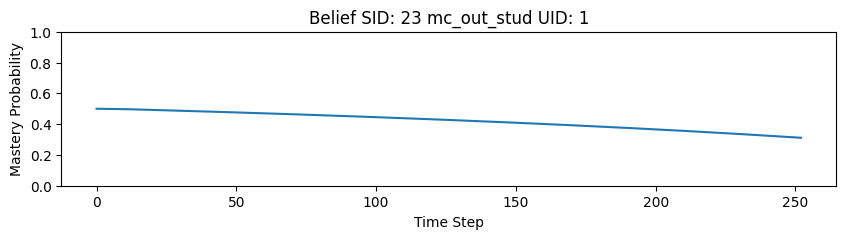

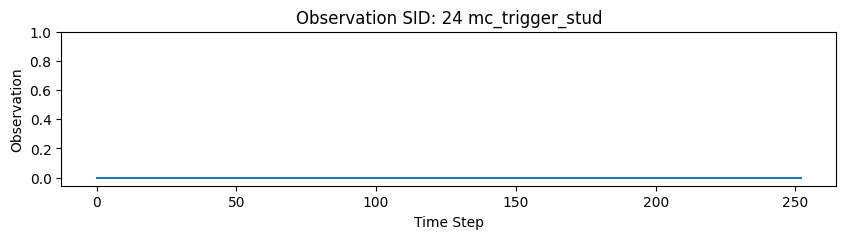

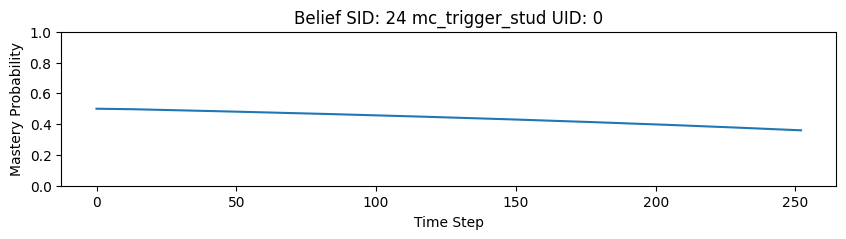

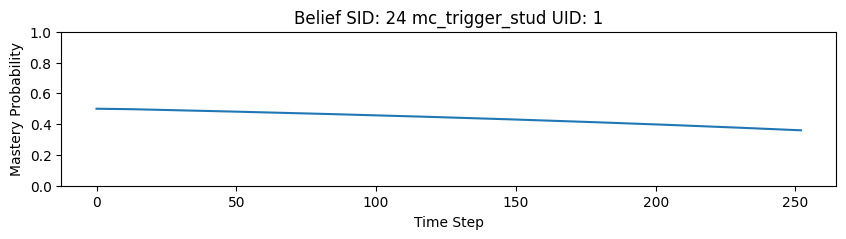

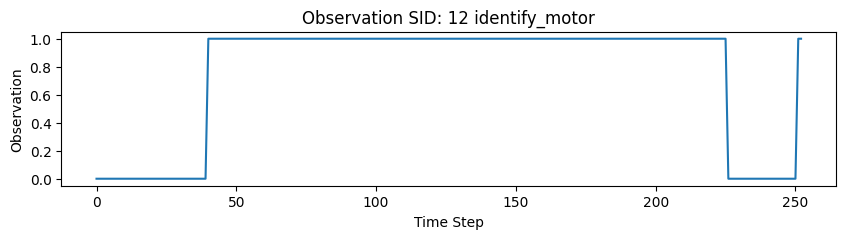

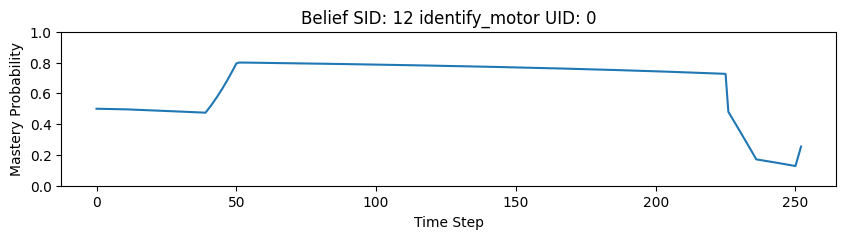

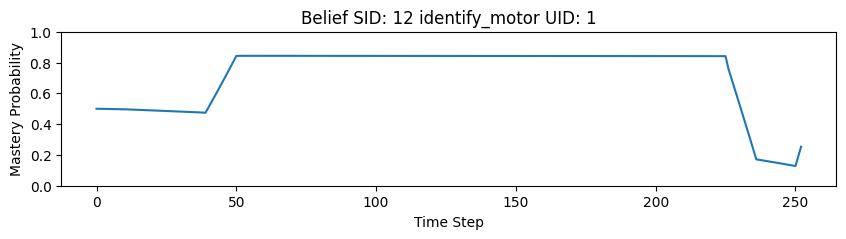

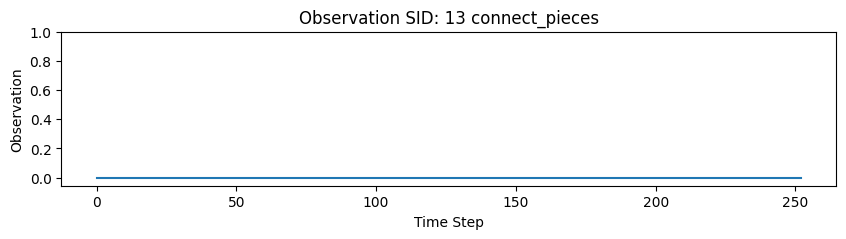

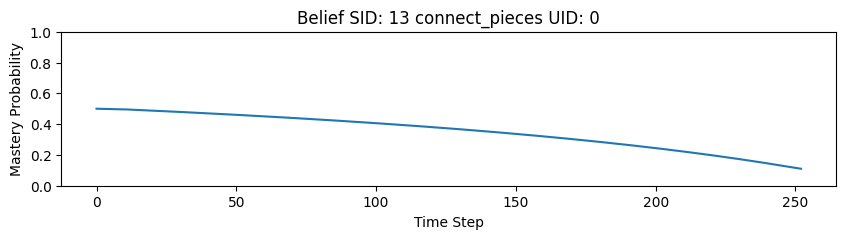

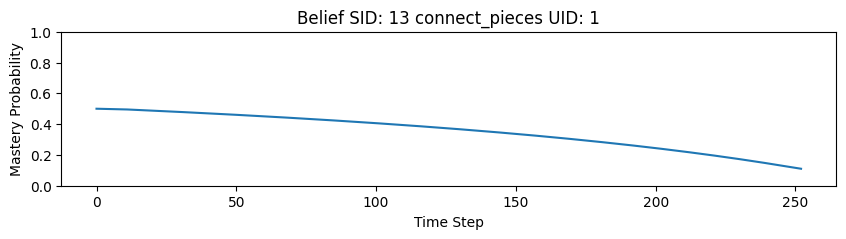

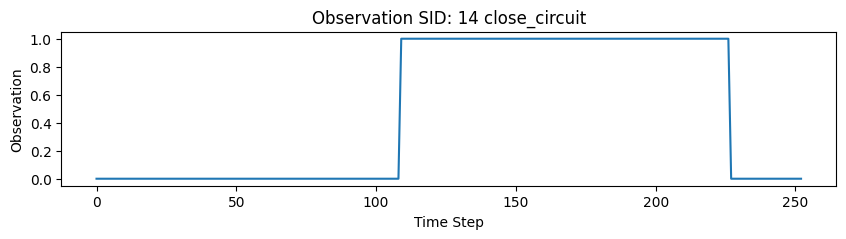

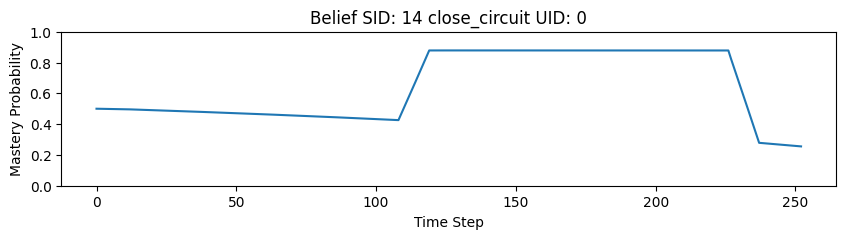

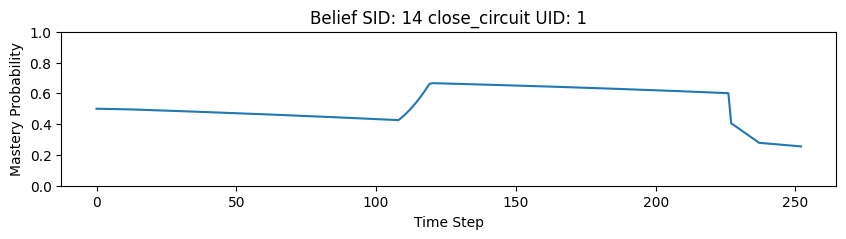

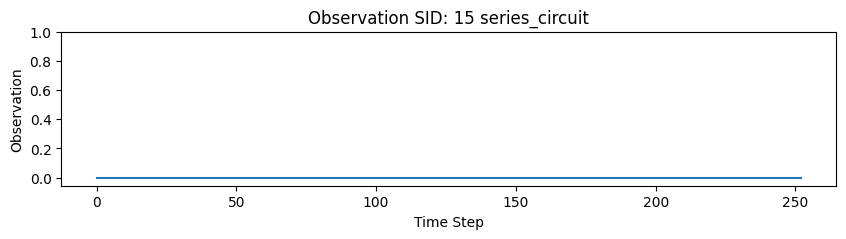

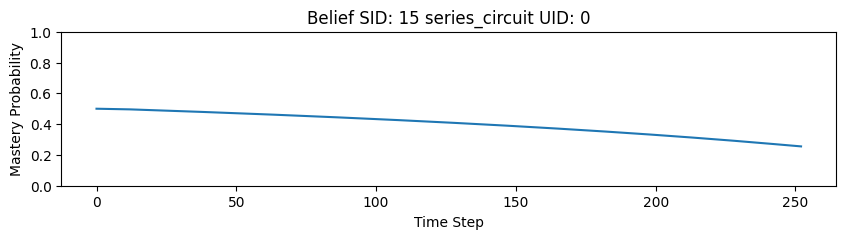

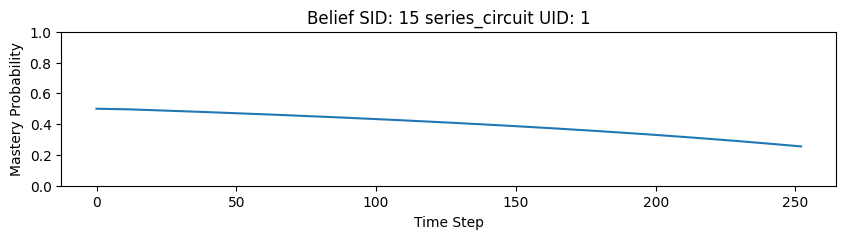

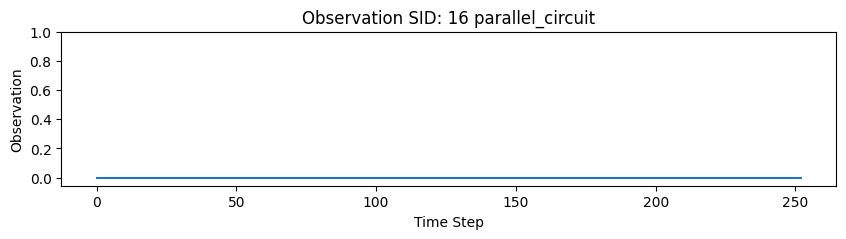

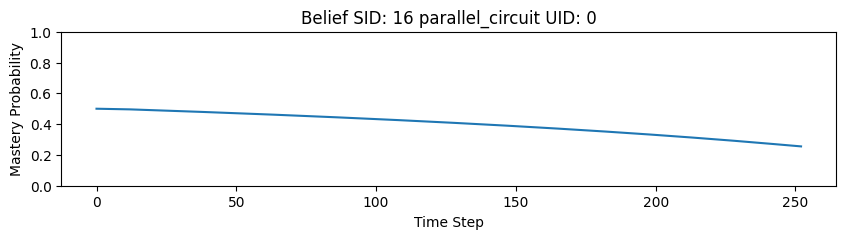

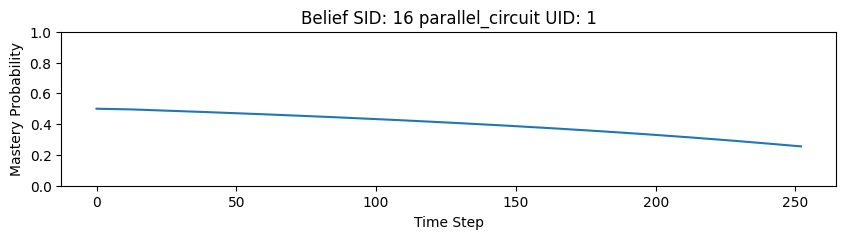

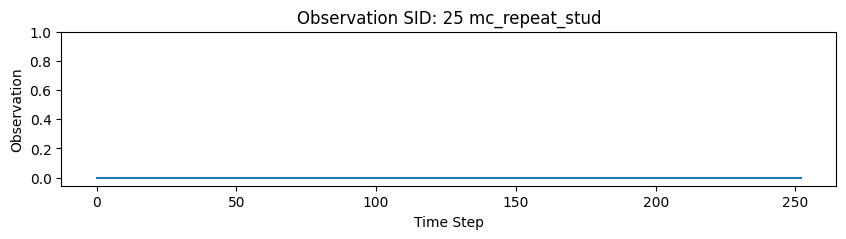

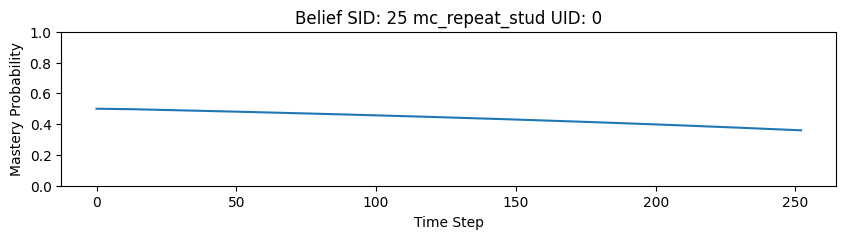

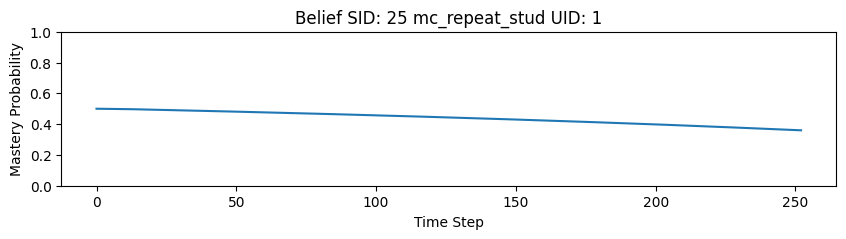

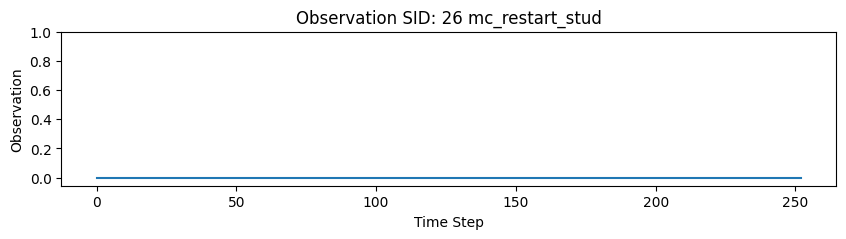

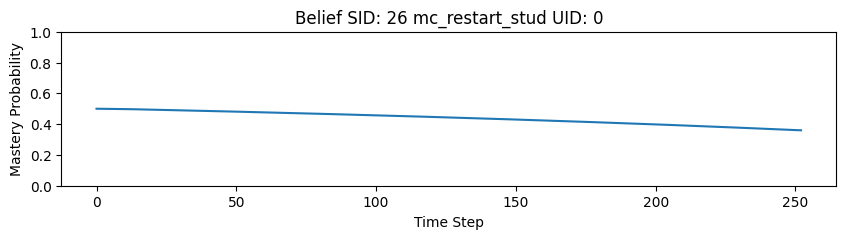

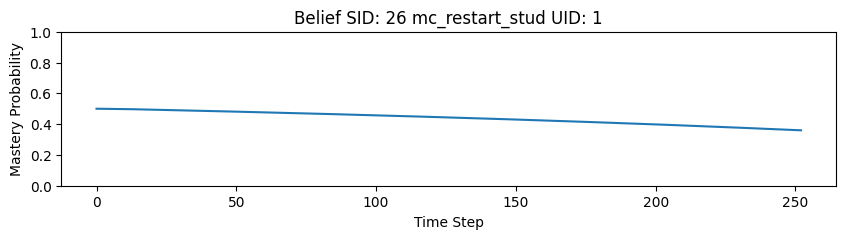

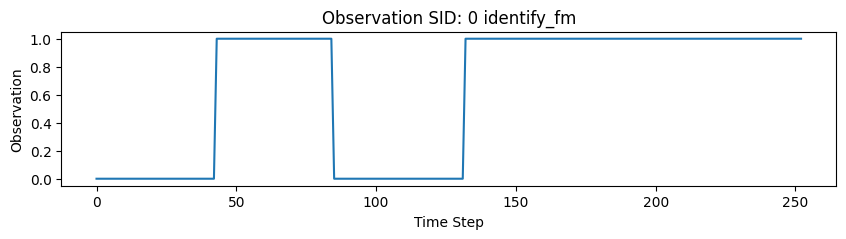

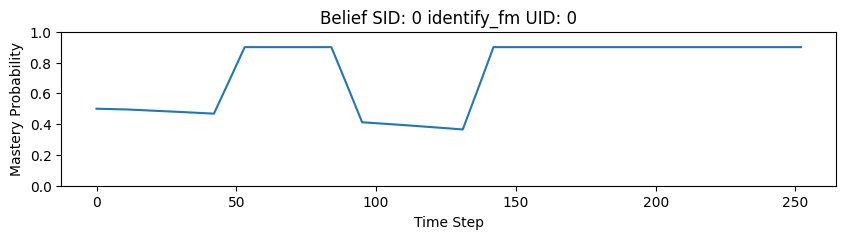

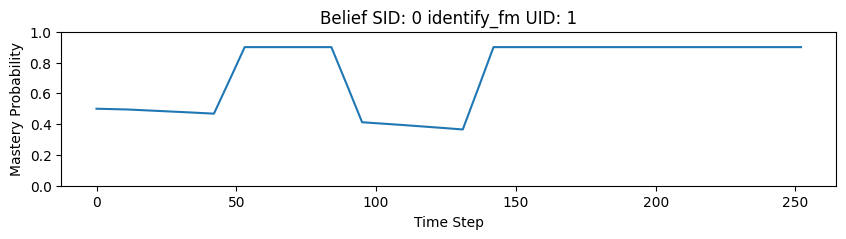

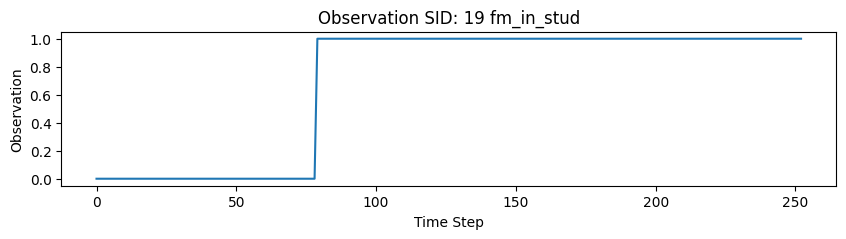

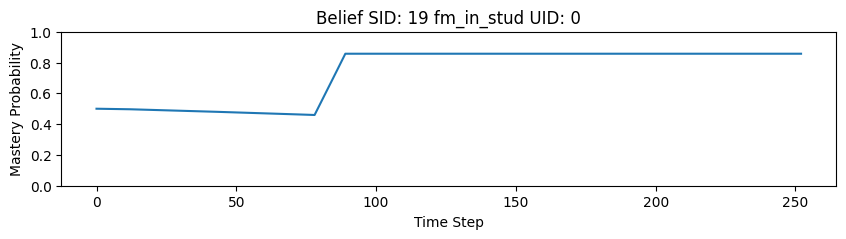

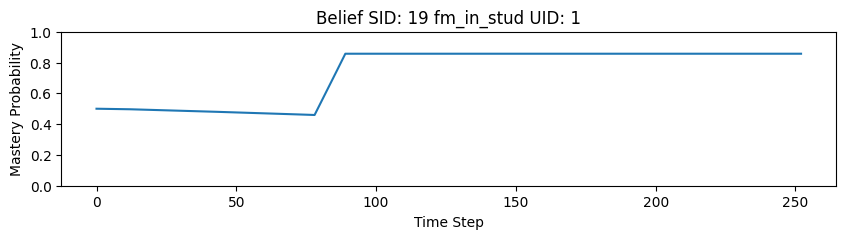

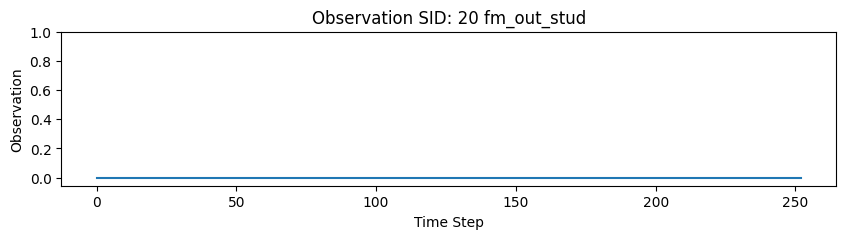

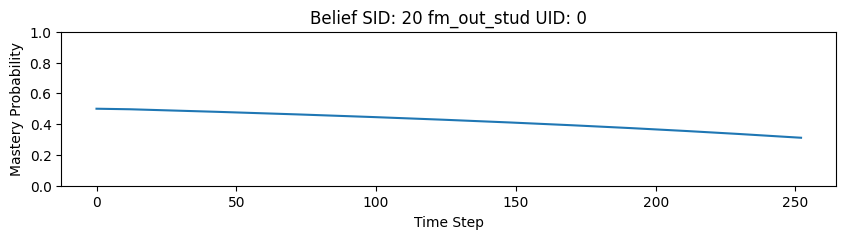

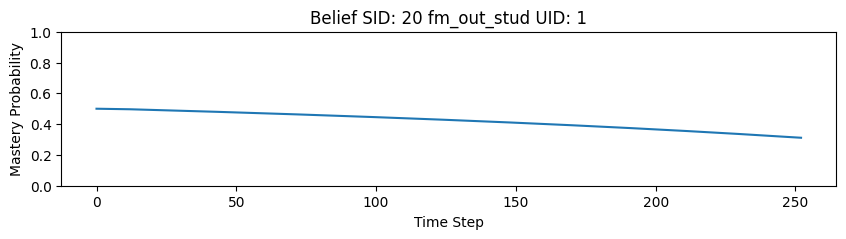

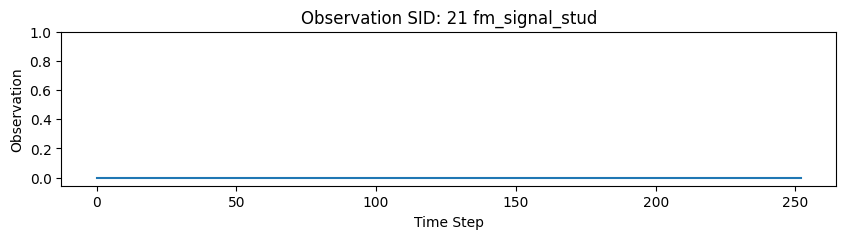

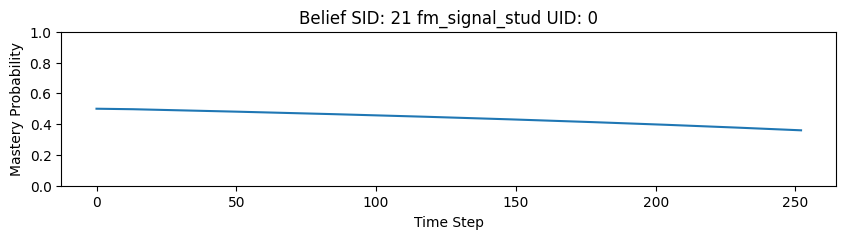

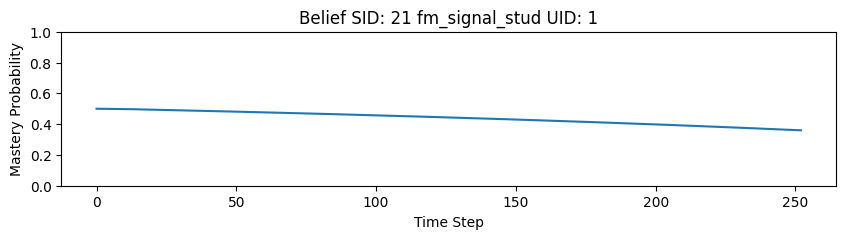

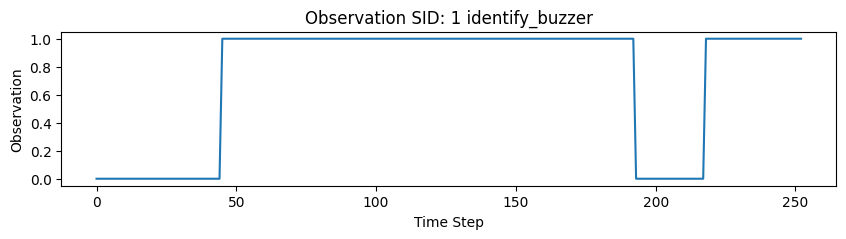

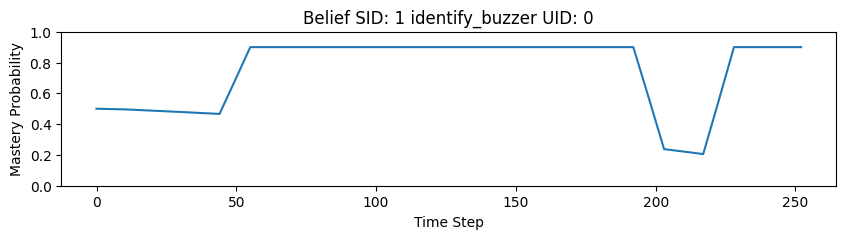

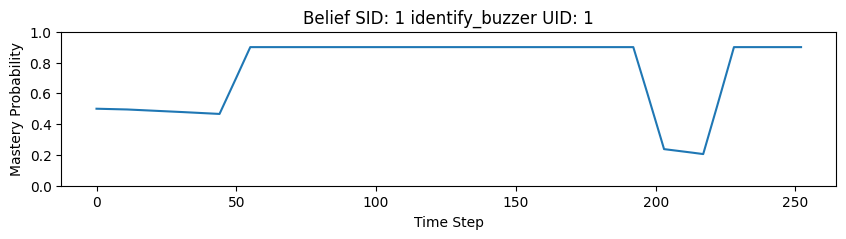

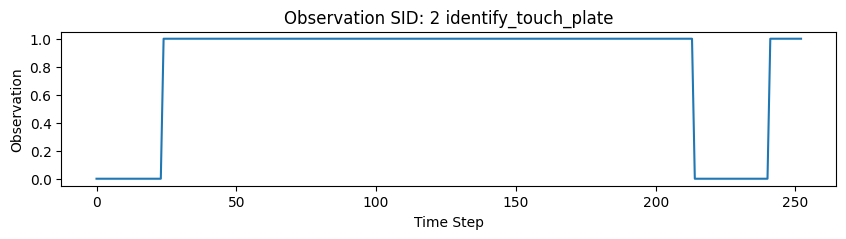

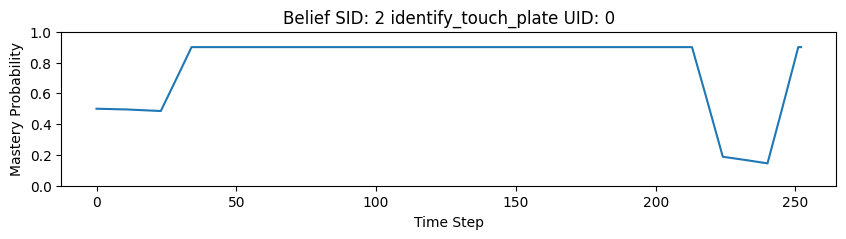

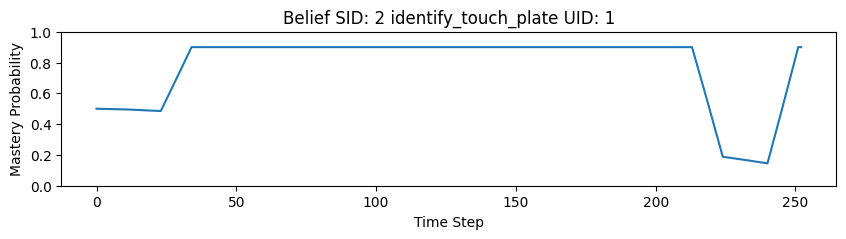

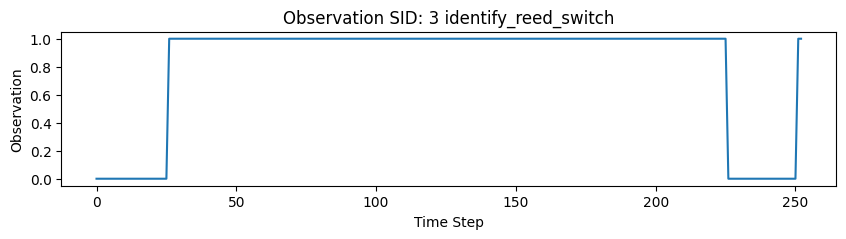

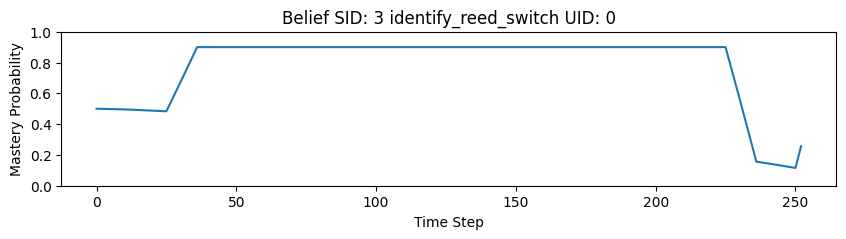

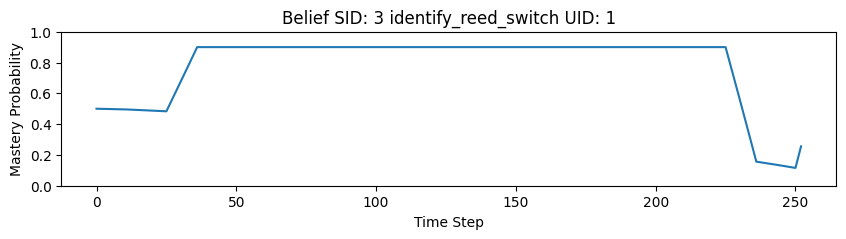

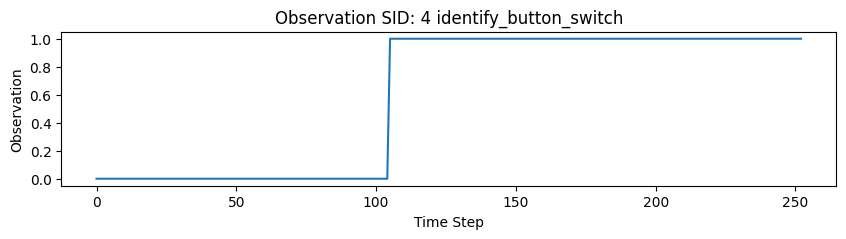

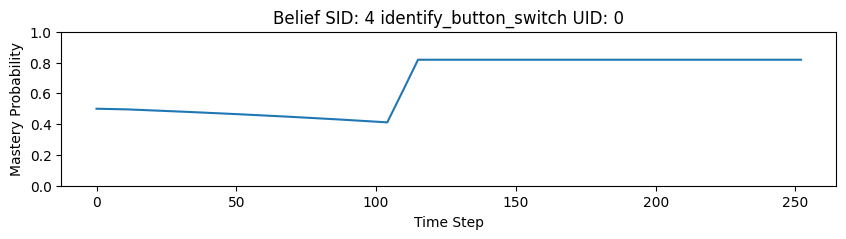

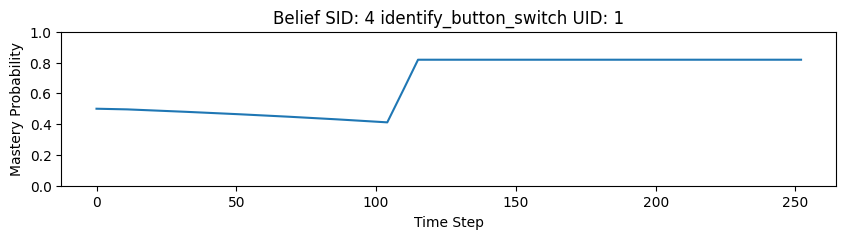

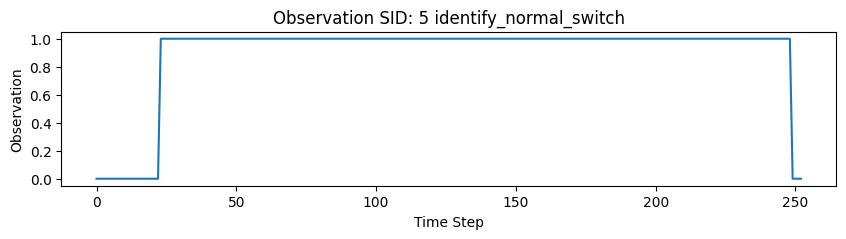

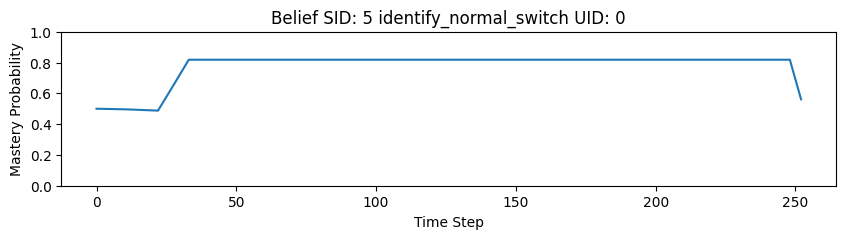

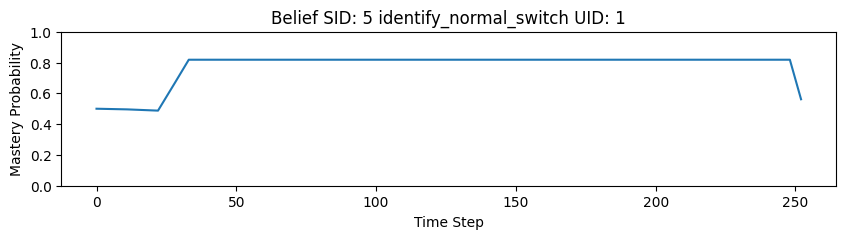

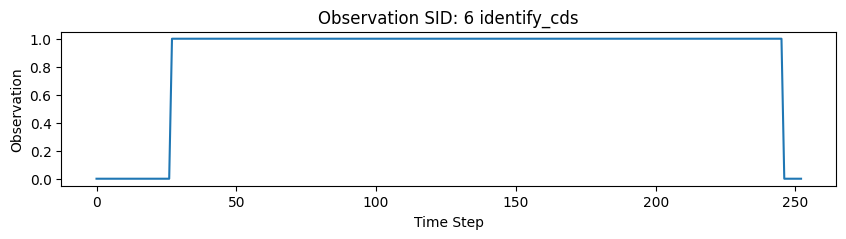

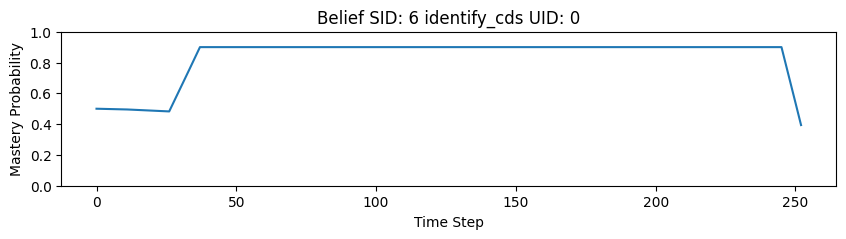

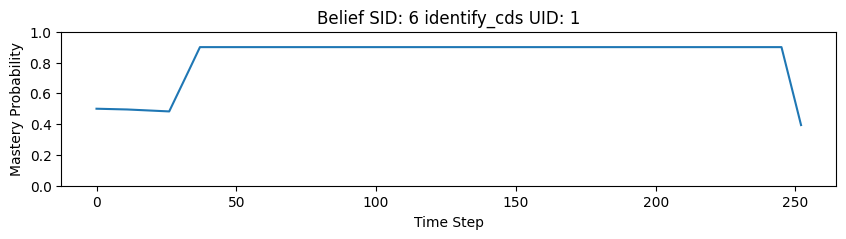

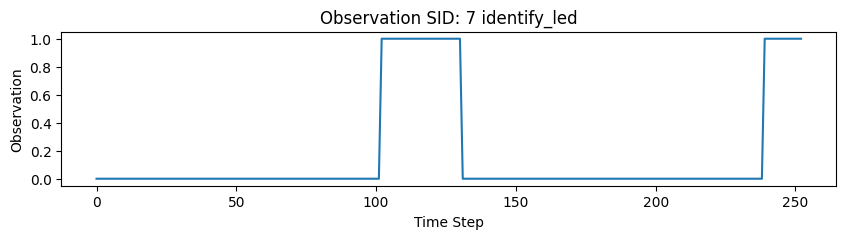

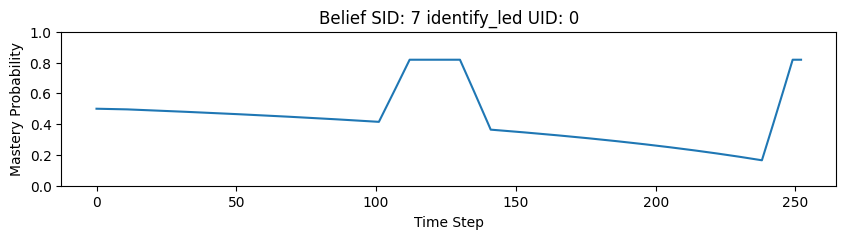

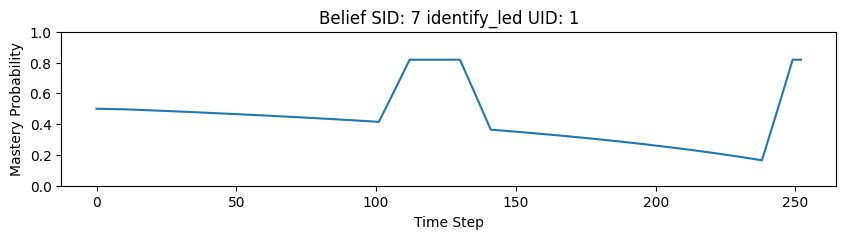

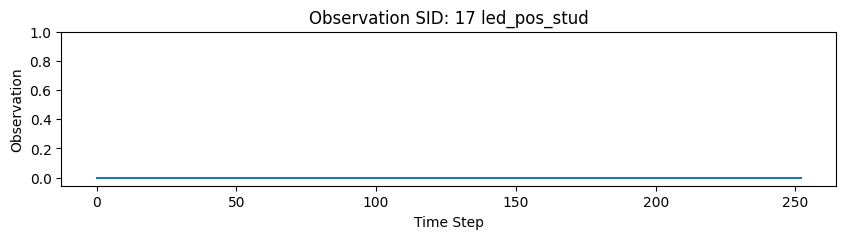

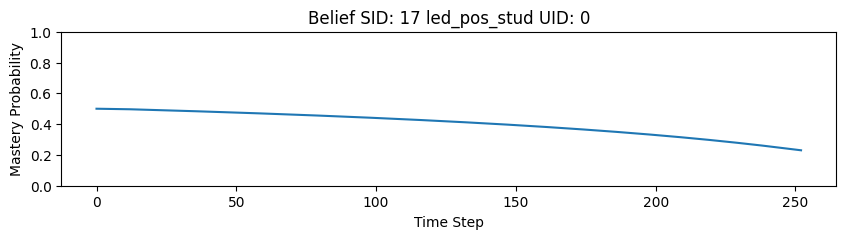

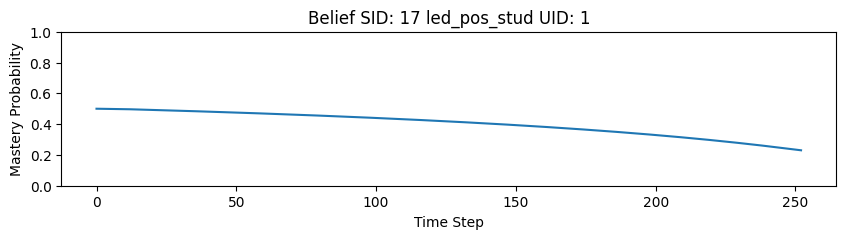

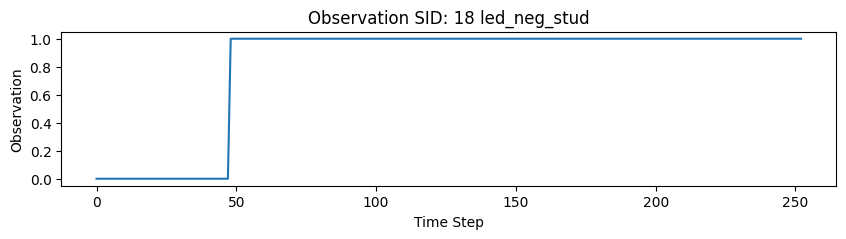

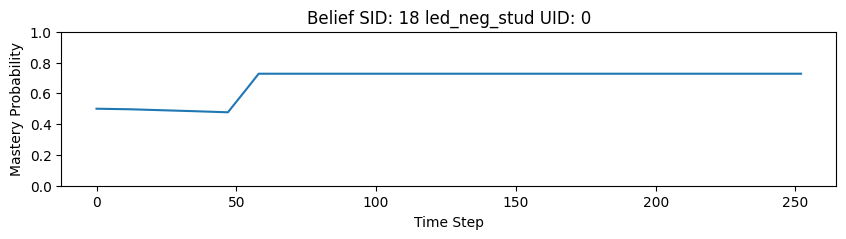

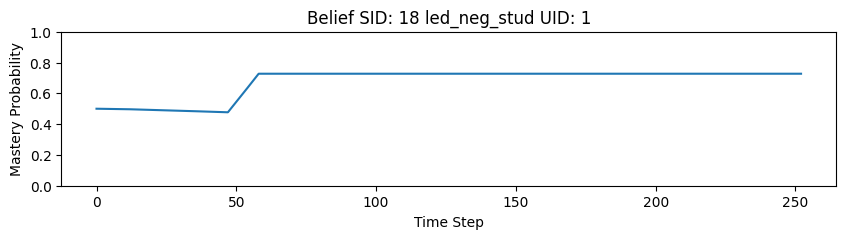

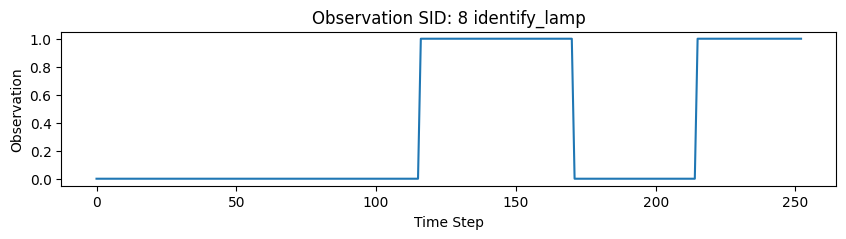

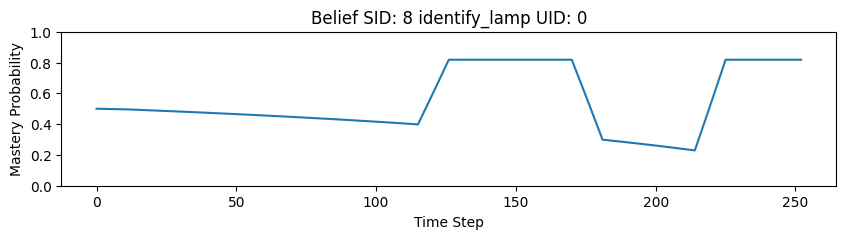

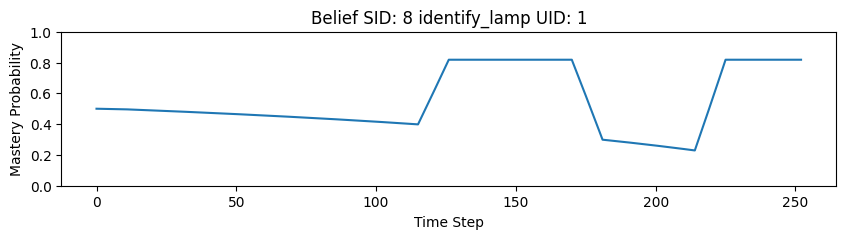

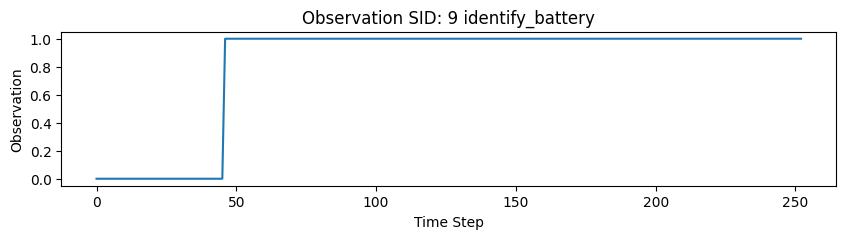

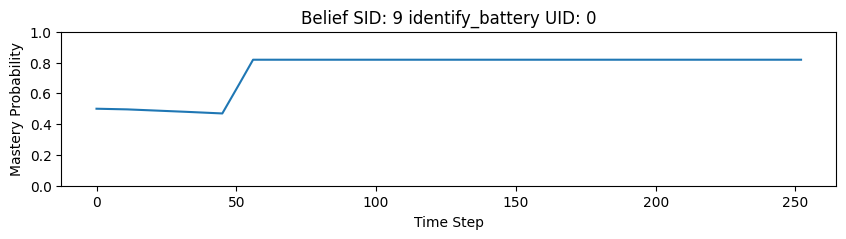

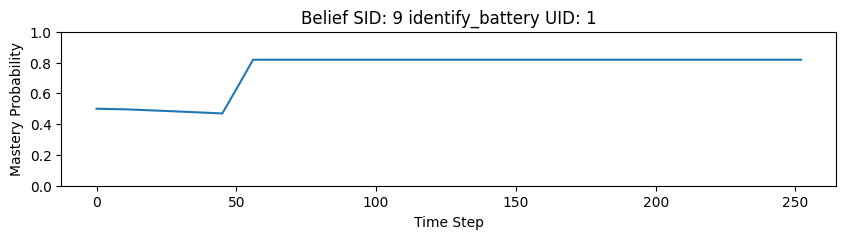

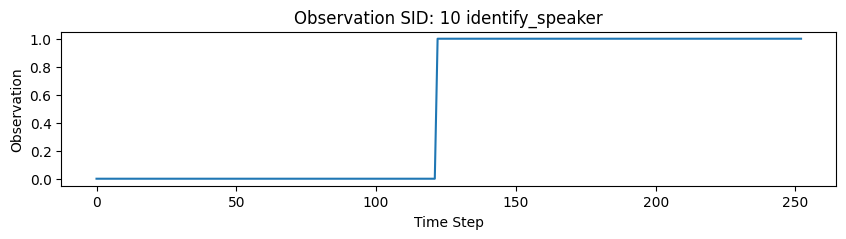

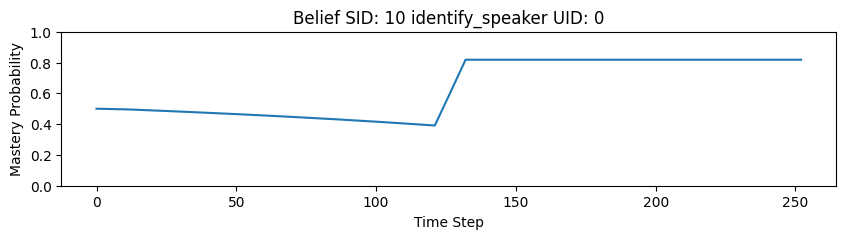

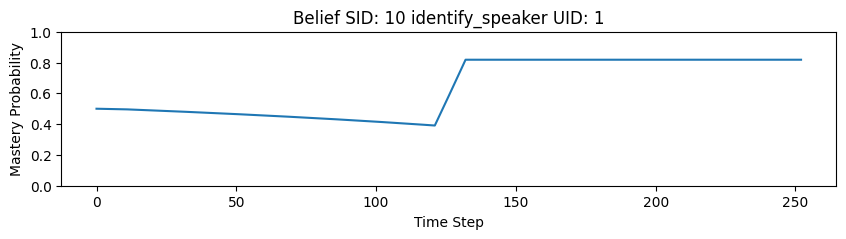

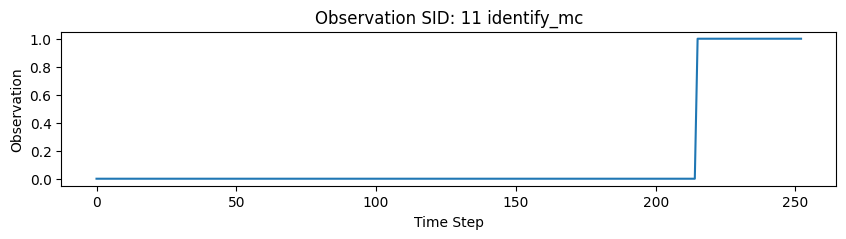

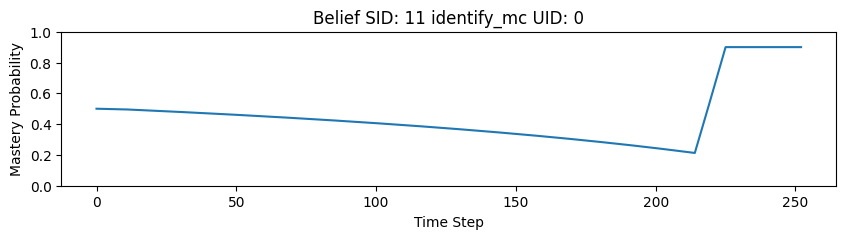

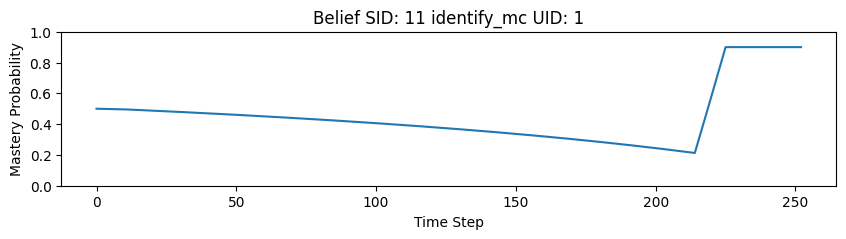

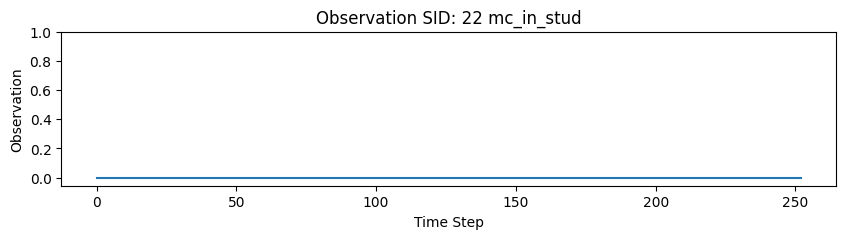

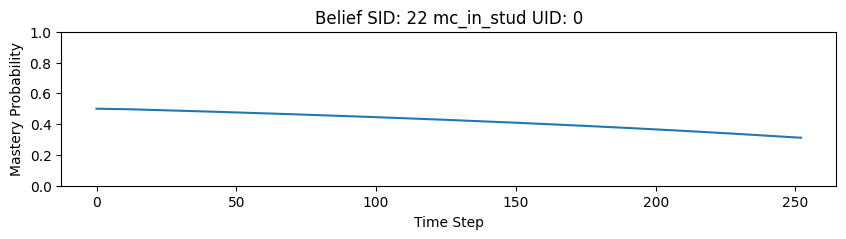

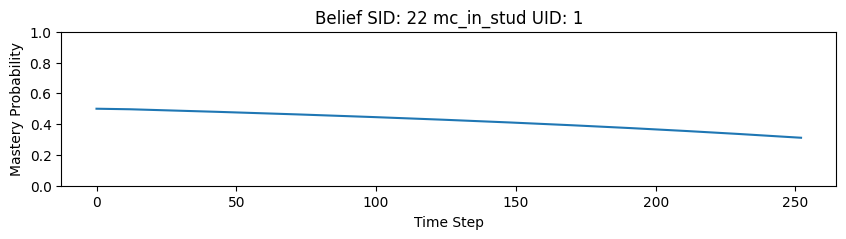

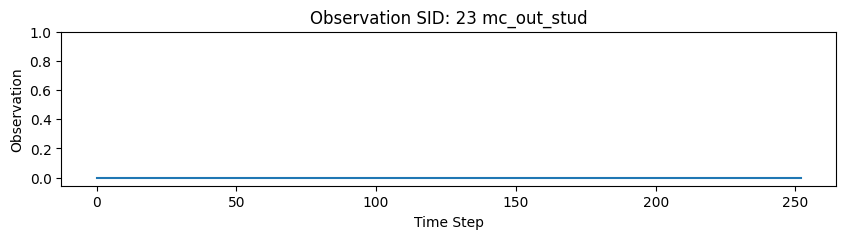

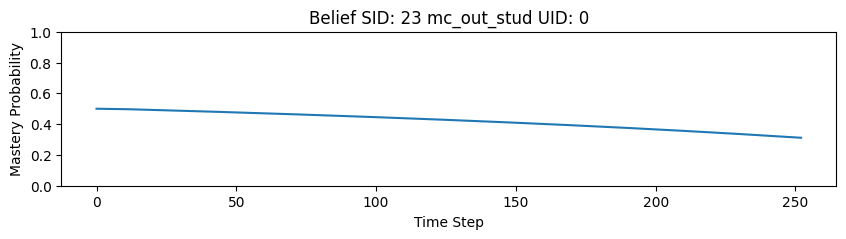

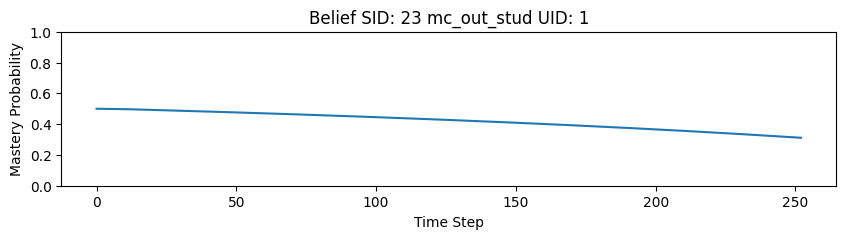

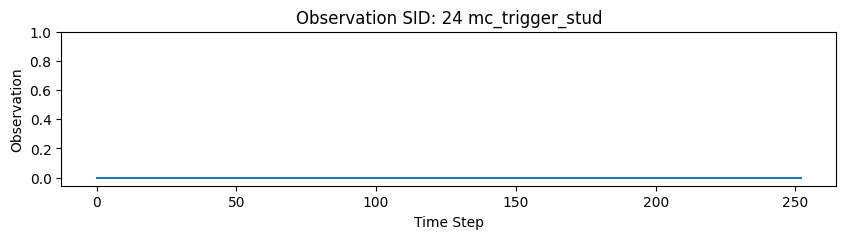

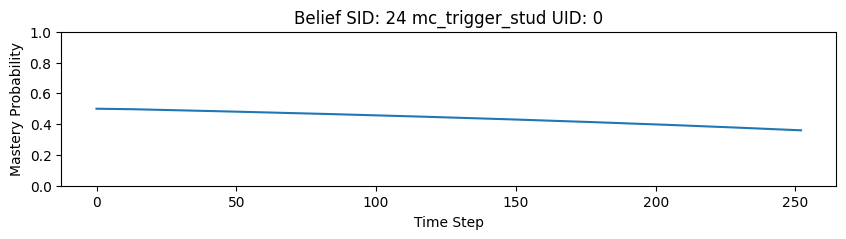

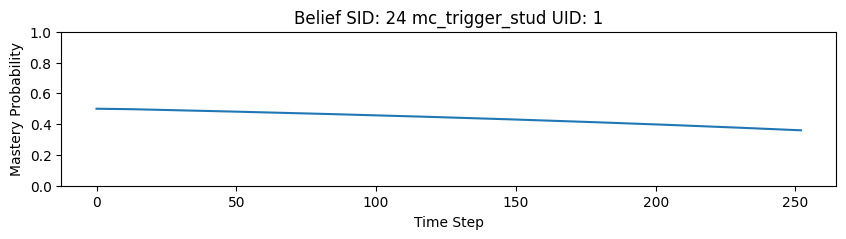

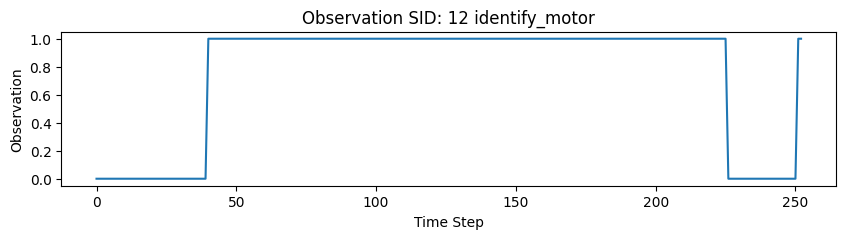

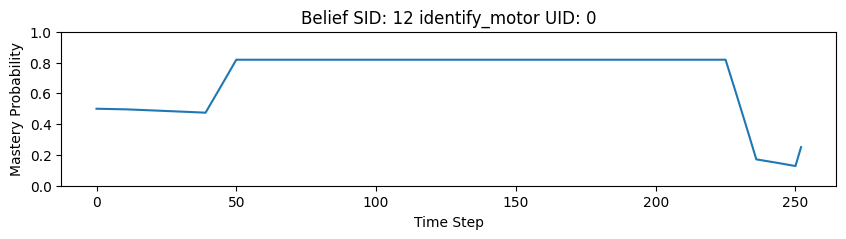

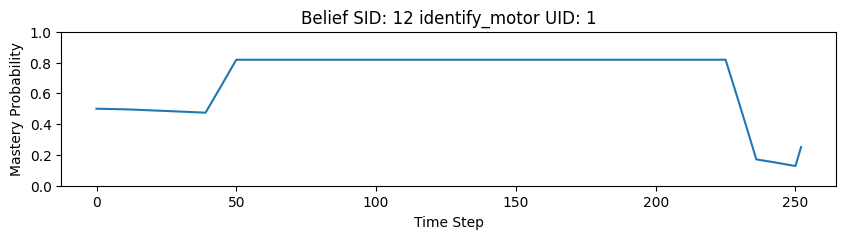

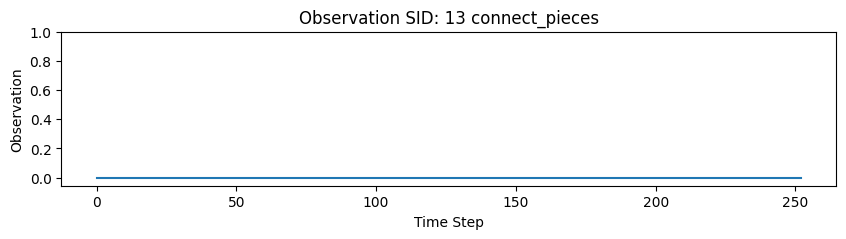

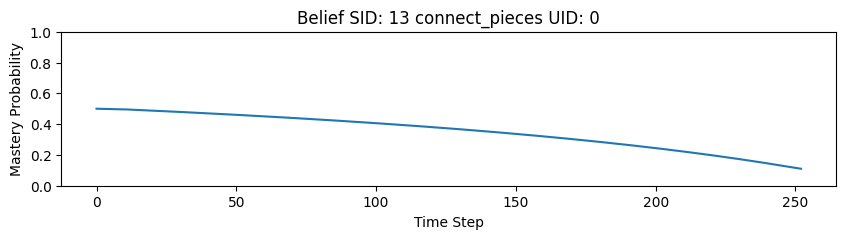

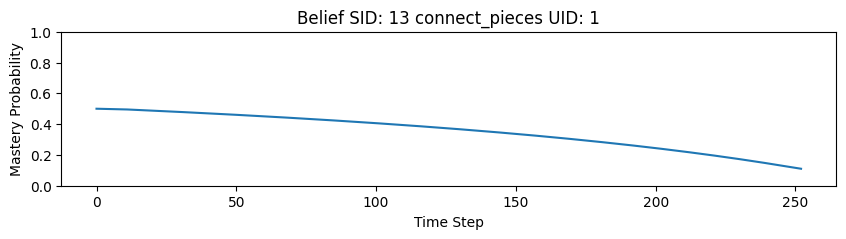

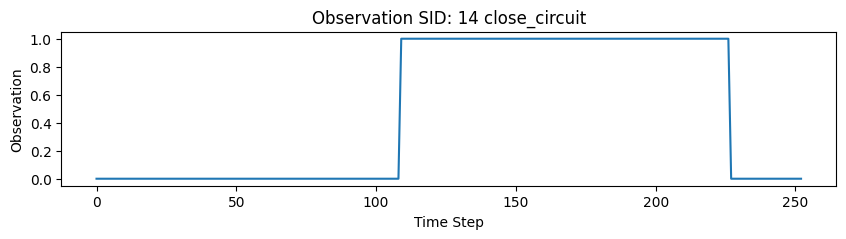

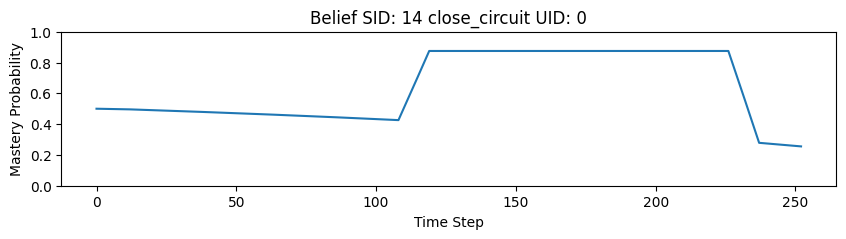

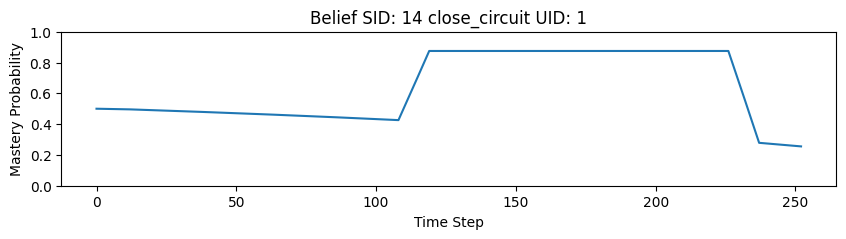

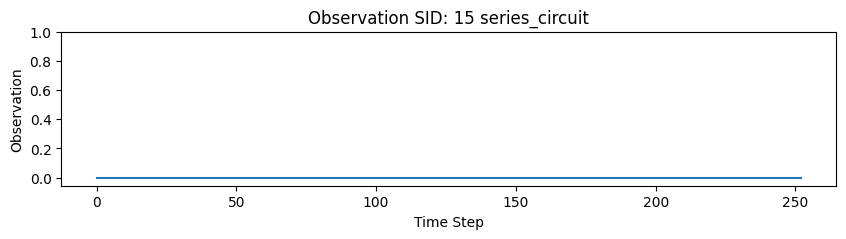

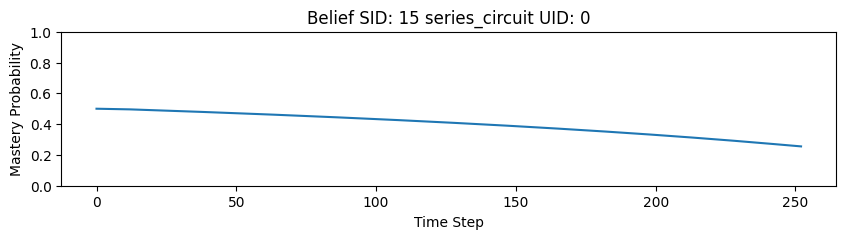

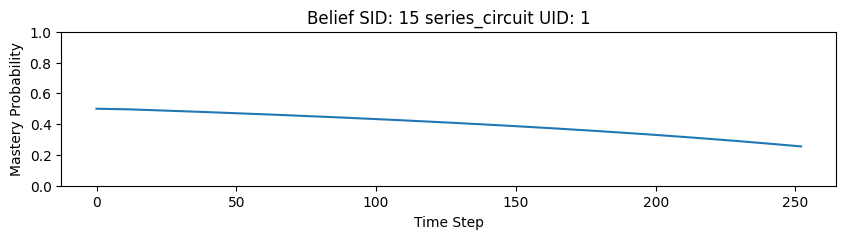

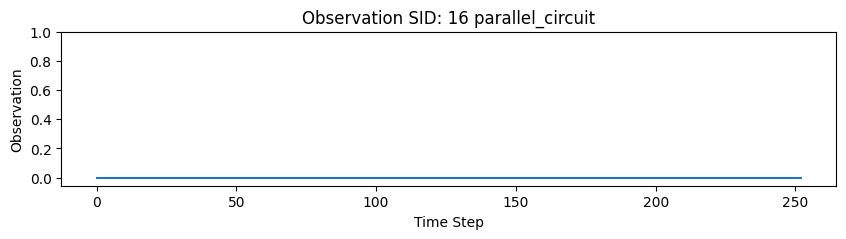

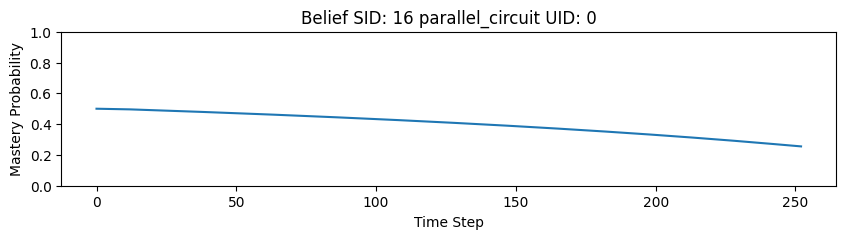

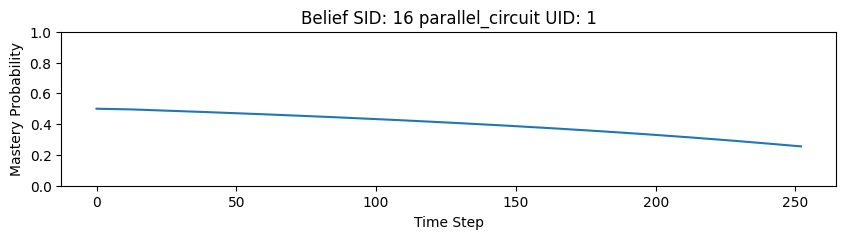

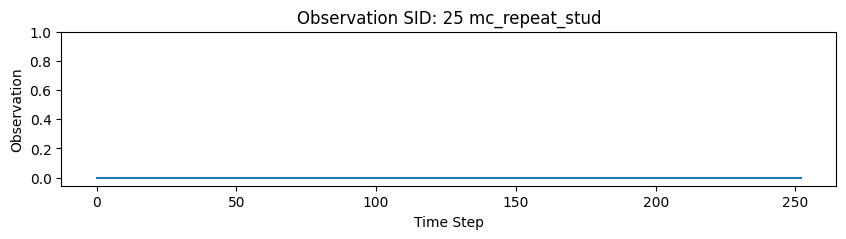

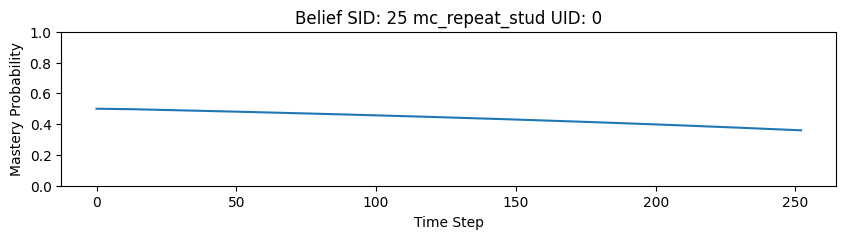

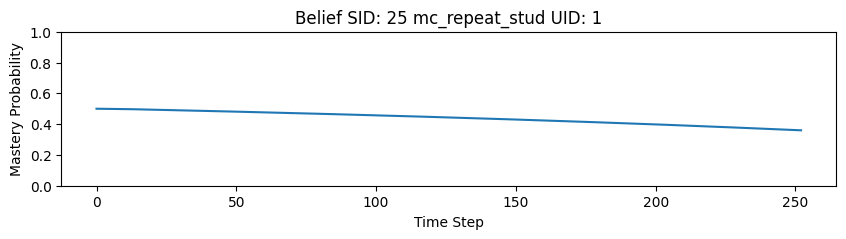

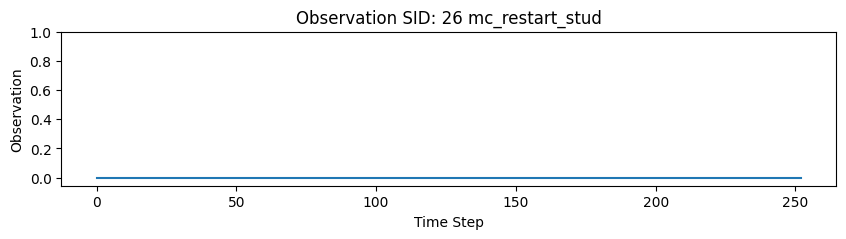

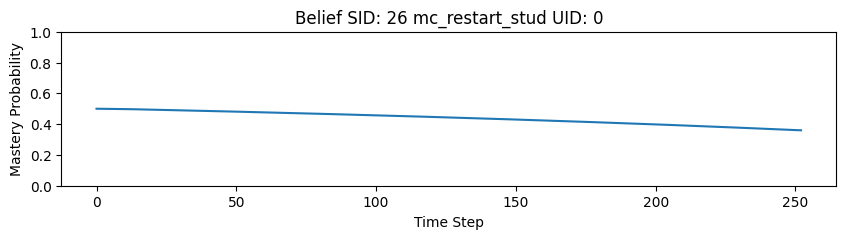

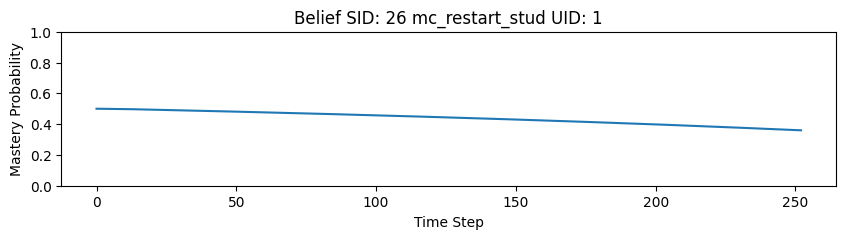

In [9]:
collab_tdbkts, tdbkts, real_masteries, collab_believed_masteries, solo_believed_masteries = simulate_task(uids, current_real_masteries, collab_believed_masteries, solo_believed_masteries, 100, 150)
dist_new = find_correctness(collab_tdbkts, real_masteries)
dist_old = find_correctness(tdbkts, real_masteries)
print(dist_new)
print(dist_old)

current_real_masteries = {}
for uid in uids:
    current_real_masteries[uid] = {}
    for sid in tasks.sid_skill_map:
        current_real_masteries[uid][sid] = real_masteries[uid][sid][-1]

plot_masteries(real_masteries)
belief.plot_beliefs(beliefs=collab_tdbkts)
belief.plot_beliefs(beliefs=tdbkts)


In [10]:
collab_tdbkts, tdbkts, real_masteries, collab_believed_masteries, solo_believed_masteries = simulate_task(uids, current_real_masteries, collab_believed_masteries, solo_believed_masteries, 100, 150)
dist_new = find_correctness(collab_tdbkts, real_masteries)
dist_old = find_correctness(tdbkts, real_masteries)
print(dist_new)
print(dist_old)

current_real_masteries = {}
for uid in uids:
    current_real_masteries[uid] = {}
    for sid in tasks.sid_skill_map:
        current_real_masteries[uid][sid] = real_masteries[uid][sid][-1]

# plot_masteries(real_masteries)
# belief.plot_beliefs(beliefs=collab_tdbkts)
# belief.plot_beliefs(beliefs=tdbkts)

[0, 19, 20, 21, 6, 9, 10, 11, 22, 23, 24, 13, 14, 18, 20, 23, 24]
4.315768898825287
4.3660851012559805


In [11]:
collab_tdbkts, tdbkts, real_masteries, collab_believed_masteries, solo_believed_masteries = simulate_task(uids, current_real_masteries, collab_believed_masteries, solo_believed_masteries, 100, 150)
dist_new = find_correctness(collab_tdbkts, real_masteries)
dist_old = find_correctness(tdbkts, real_masteries)
print(dist_new)
print(dist_old)

current_real_masteries = {}
for uid in uids:
    current_real_masteries[uid] = {}
    for sid in tasks.sid_skill_map:
        current_real_masteries[uid][sid] = real_masteries[uid][sid][-1]

# plot_masteries(real_masteries)
# belief.plot_beliefs(beliefs=collab_tdbkts)
# belief.plot_beliefs(beliefs=tdbkts)

[0, 19, 20, 21, 1, 2, 3, 5, 6, 7, 17, 18, 9, 10, 11, 22, 23, 25, 12, 13, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26]
3.5536000510136865
3.660006623954647


In [12]:
collab_tdbkts, tdbkts, real_masteries, collab_believed_masteries, solo_believed_masteries = simulate_task(uids, current_real_masteries, collab_believed_masteries, solo_believed_masteries, 100, 150)
dist_new = find_correctness(collab_tdbkts, real_masteries)
dist_old = find_correctness(tdbkts, real_masteries)
print(dist_new)
print(dist_old)

current_real_masteries = {}
for uid in uids:
    current_real_masteries[uid] = {}
    for sid in tasks.sid_skill_map:
        current_real_masteries[uid][sid] = real_masteries[uid][sid][-1]

# plot_masteries(real_masteries)
# belief.plot_beliefs(beliefs=collab_tdbkts)
# belief.plot_beliefs(beliefs=tdbkts)

[9, 10, 13, 14, 15, 20, 22, 24]
2.2316048427973234
2.274228987060028
